In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
epoch_key = ('HPa', 4, 2)

In [6]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.parameters import (ANIMALS, SAMPLING_FREQUENCY,
                            MULTITAPER_PARAMETERS, FREQUENCY_BANDS,
                            RIPPLE_COVARIATES)

In [4]:
from src.analysis import detect_epoch_ripples

ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, sampling_frequency=SAMPLING_FREQUENCY)

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


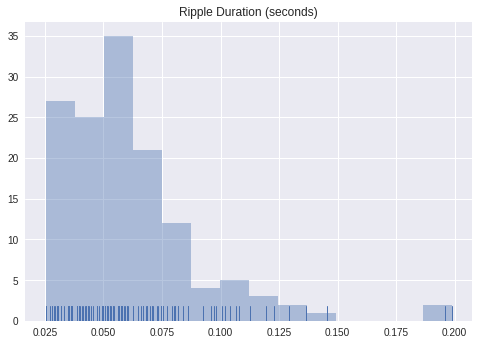

In [7]:
ripple_times = np.array(ripple_times)
ripple_duration = ripple_times[:, 1] - ripple_times[:, 0]
sns.distplot(ripple_duration, kde=False, rug=True);
plt.title('Ripple Duration (seconds)');

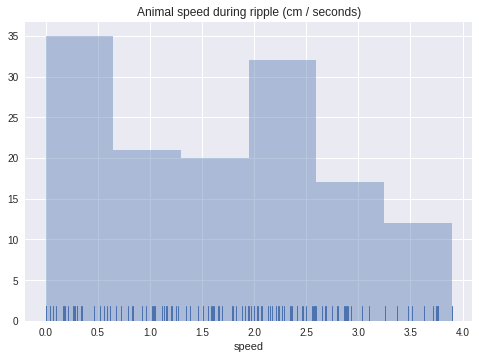

In [8]:
from src.data_processing import get_interpolated_position_dataframe

position_df = get_interpolated_position_dataframe(
    epoch_key, ANIMALS)
ripple_position = position_df.loc[ripple_times[:, 0]]

sns.distplot(ripple_position.speed, kde=False, rug=True);
plt.title('Animal speed during ripple (cm / seconds)');

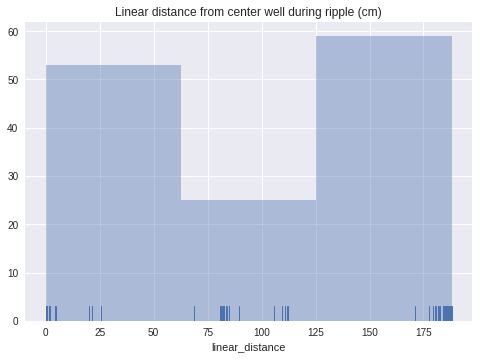

In [9]:
sns.distplot(ripple_position.linear_distance, rug=True, hist=True, kde=False);
plt.title('Linear distance from center well during ripple (cm)');

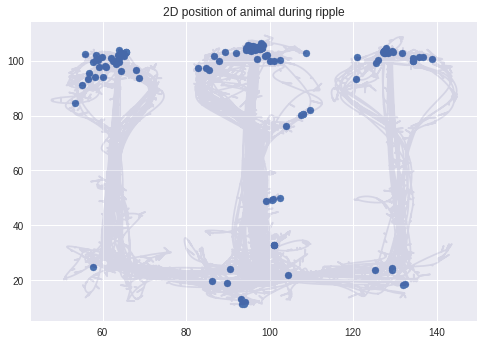

In [10]:
plt.plot(position_df.x_position, position_df.y_position, alpha=0.1, color='midnightblue')
hb = plt.scatter(ripple_position.x_position, ripple_position.y_position);
plt.title('2D position of animal during ripple');

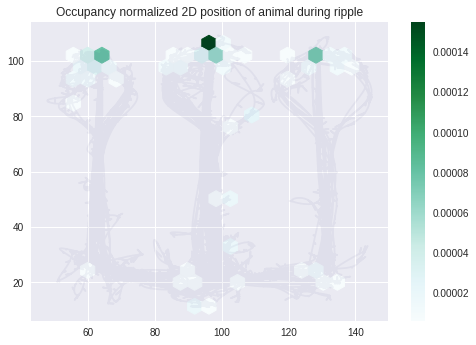

In [11]:
plt.subplot(111)
hb = plt.hexbin(position_df.x_position, position_df.y_position, gridsize=20)
plt.cla()
plt.plot(position_df.x_position, position_df.y_position, alpha=0.05, color='midnightblue')
plt.hexbin(ripple_position.x_position, ripple_position.y_position, gridsize=20,
           C=np.ones_like(position_df.y_position, dtype=np.float) / hb.get_array().max(),
           reduce_C_function=np.sum, cmap='BuGn')
cb = plt.colorbar();
plt.title('Occupancy normalized 2D position of animal during ripple');

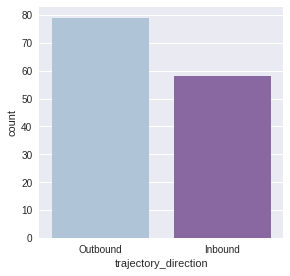

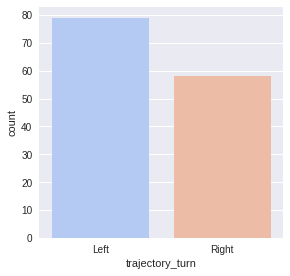

In [12]:
g = sns.factorplot(x="trajectory_direction", data=ripple_position, kind="count",
                   palette="BuPu")
g = sns.factorplot(x="trajectory_turn", data=ripple_position, kind='count',
                   palette="coolwarm")

In [13]:
from src.data_processing import (get_LFP_dataframe, make_tetrode_dataframe)

tetrode_info = make_tetrode_dataframe(ANIMALS)[epoch_key]
tetrode_info = tetrode_info[
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False)]
    
lfps = {tetrode_key: get_LFP_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in tetrode_info.index}

tetrode_info

area  depth descrip  numcells animal  day  \
animal day epoch tetrode_number                                              
HPa    4   2     1                CA1    114  riptet        10    HPa    4   
                 2                CA1    121     NaN         0    HPa    4   
                 4                CA1    117  riptet        15    HPa    4   
                 5                CA1    117  riptet         3    HPa    4   
                 6                CA1    110  riptet         0    HPa    4   
                 7                CA1    114  riptet         1    HPa    4   
                 8               iCA1    114  riptet         2    HPa    4   
                 9               iCA1    101  riptet         2    HPa    4   
                 10              iCA1     98     NaN         0    HPa    4   
                 11              iCA1    108  riptet         1    HPa    4   
                 12              iCA1    116  riptet         0    HPa    4   
                 13              iCA1    120     NaN         0    HPa    4   
                 14              iCA1    105  riptet         4    HPa    4   
                 15               PFC    116     NaN         3    HPa    4   
                 16               PFC    118     NaN         0    HPa    4   
                 17               PFC    119     NaN         0    HPa    4   
                 18               PFC    108     NaN         0    HPa    4   
                 19               PFC    126     NaN         0    HPa    4   
                 20               PFC    109     NaN         0    HPa    4   

                                 epoch  tetrode_number tetrode_id  
animal day epoch tetrode_number                                    
HPa    4   2     1                   2               1     HPa421  
                 2                   2               2     HPa422  
                 4                   2               4     HPa424  
                 5                   2               5     HPa425  
                 6                   2               6     HPa426  
                 7                   2               7     HPa427  
                 8                   2               8     HPa428  
                 9                   2               9     HPa429  
                 10                  2              10    HPa4210  
                 11                  2              11    HPa4211  
                 12                  2              12    HPa4212  
                 13                  2              13    HPa4213  
                 14                  2              14    HPa4214  
                 15                  2              15    HPa4215  
                 16                  2              16    HPa4216  
                 17                  2              17    HPa4217  
                 18                  2              18    HPa4218  
                 19                  2              19    HPa4219  
                 20                  2              20    HPa4220

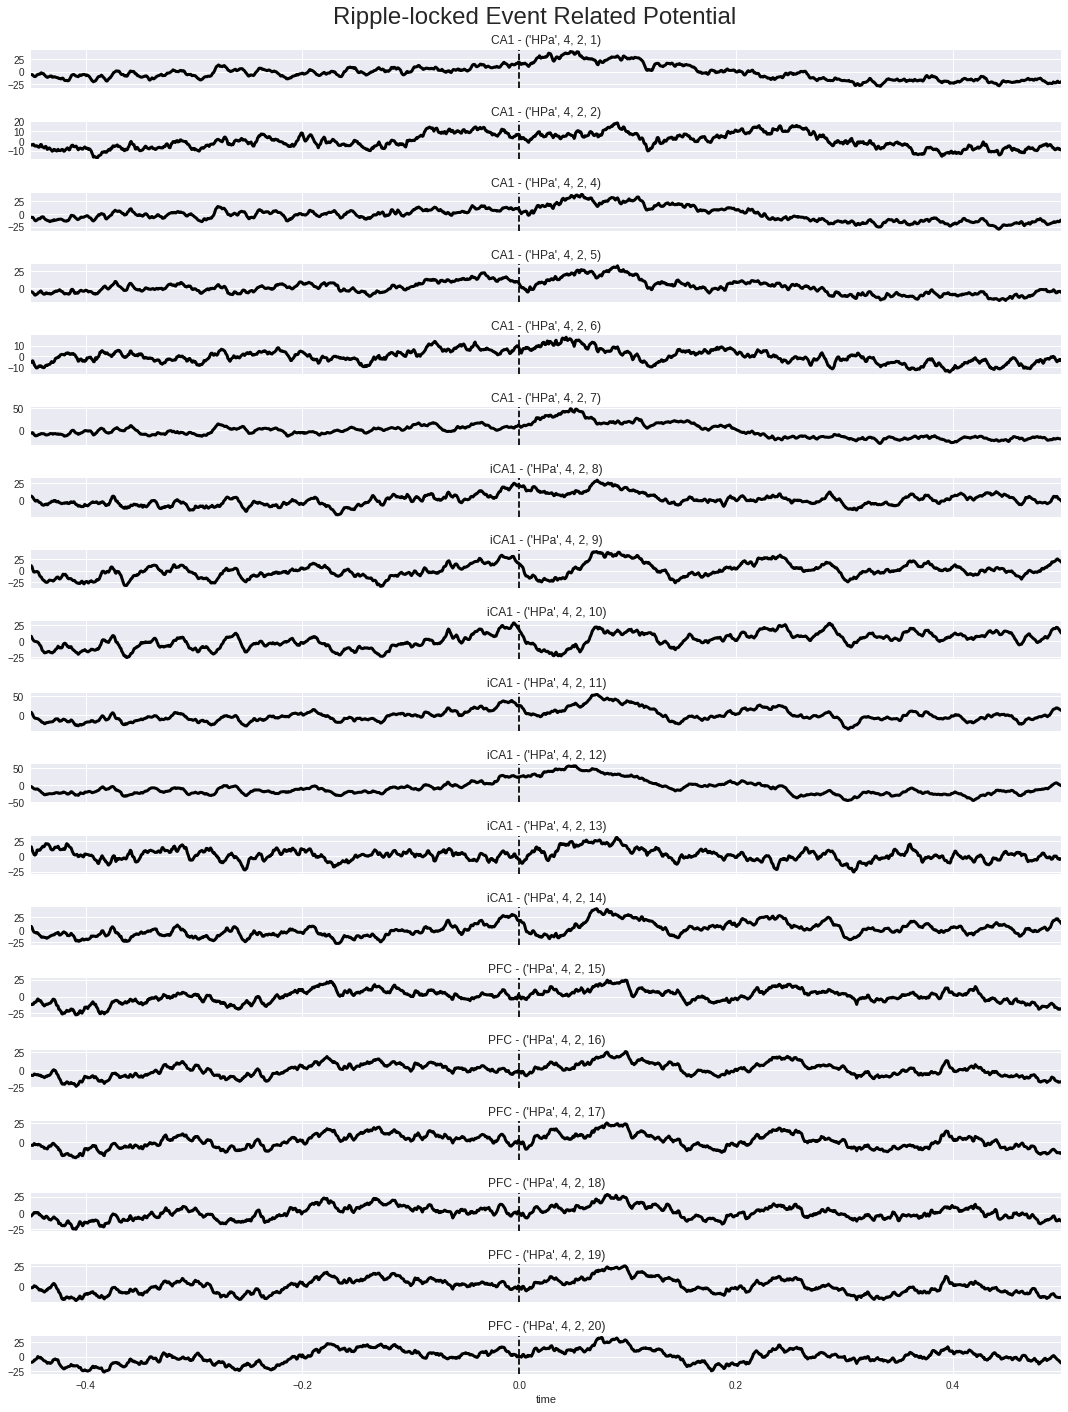

In [20]:
from copy import deepcopy
from functools import partial
from src.data_processing import reshape_to_segments
from src.analysis import _subtract_event_related_potential

params = deepcopy(MULTITAPER_PARAMETERS['20Hz_Resolution'])
window_of_interest = params.pop('window_of_interest')
reshape_to_trials = partial(
    reshape_to_segments,
    sampling_frequency=params['sampling_frequency'],
    window_offset=window_of_interest, concat_axis=1)

fig, axes = plt.subplots(len(tetrode_info), 1, figsize=(15, 1 * (len(tetrode_info) + 1)), sharex=True)
for ax, (tetrode_key, info) in zip(axes, tetrode_info.iterrows()):
    ripple_locked_lfp = reshape_to_trials(lfps[tetrode_key], ripple_times)
    ripple_locked_lfp.mean(axis=1).plot(color='black', linewidth=3, ax=ax);
    ax.axvline(0, color='black', linestyle='--');
    ax.set_title('{brain_area} - {tetrode_id}'.format(brain_area=info.area, tetrode_id=tetrode_key))
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Ripple-locked Event Related Potential', fontsize=24);

In [24]:
from src.spectral.connectivity import Connectivity
from src.spectral.transforms import Multitaper

ripple_locked_lfps = pd.Panel({
    lfp_name: _subtract_event_related_potential(
        reshape_to_trials(lfps[lfp_name], ripple_times))
    for lfp_name in lfps}).dropna(axis=2)

m = Multitaper(
    np.rollaxis(ripple_locked_lfps.values, 0, 3),
    **params,
    start_time=ripple_locked_lfps.major_axis.min())
c = Connectivity.from_multitaper(m)

In [26]:
from src.analysis import _center_time

dimension_names = ['time', 'frequency', 'tetrode']
data_vars = {
 'power': (dimension_names, c.power())}
coordinates = {
    'time': _center_time(c.time),
    'frequency': c.frequencies + np.diff(c.frequencies)[0] / 2,
    'tetrode': tetrode_info.tetrode_id.values,
    'brain_area': ('tetrode', tetrode_info.area.tolist()),
}

ripple_power = xr.Dataset(data_vars, coords=coordinates).sel(
    frequency=slice(FREQUENCY_BANDS['ripple'][0], FREQUENCY_BANDS['ripple'][1])
).power

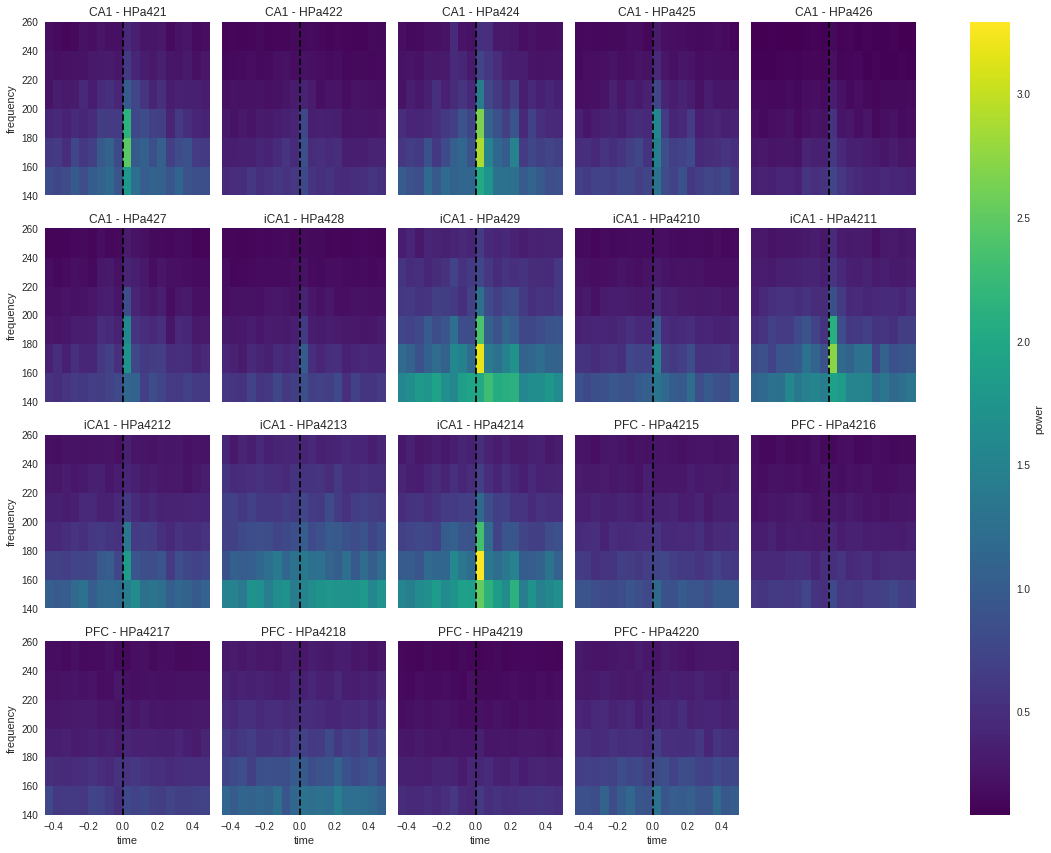

In [29]:
g = ripple_power.plot(x='time', y='frequency', col='tetrode', col_wrap=5);

for ax, area, tetrode in zip(g.axes.ravel().tolist(), g.data.brain_area, g.data.tetrode):
    ax.set_title(
        '{brain_area} - {tetrode_id}'.format(brain_area=area.values, tetrode_id=tetrode.values))
    ax.axvline(0, color='black', linestyle='--')

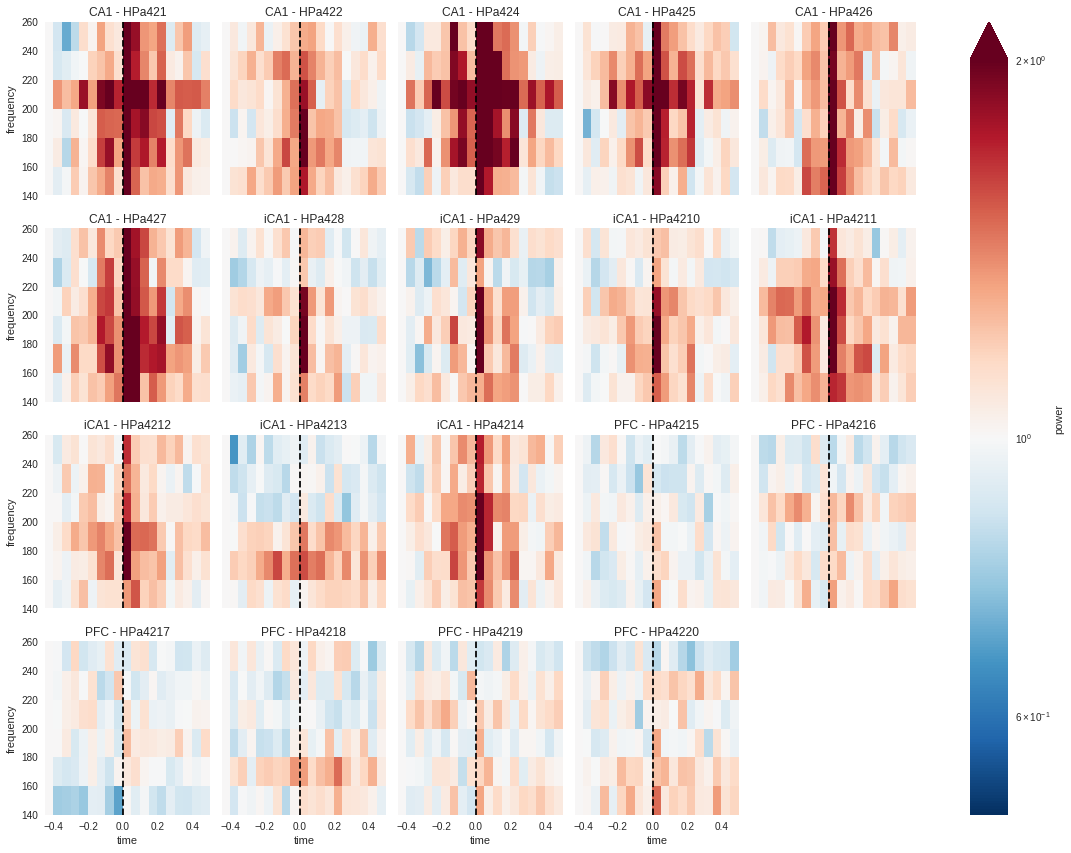

In [30]:
from matplotlib.colors import LogNorm
vmin, vmax = 0.5, 2
g = (ripple_power / ripple_power.isel(time=0)).plot(
    x='time', y='frequency', col='tetrode', col_wrap=5, center=0,
    norm=LogNorm(vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax, cmap='RdBu_r');

for ax, area, tetrode in zip(g.axes.ravel().tolist(), g.data.brain_area, g.data.tetrode):
    ax.set_title(
        '{brain_area} - {tetrode_id}'.format(brain_area=area.values, tetrode_id=tetrode.values))
    ax.axvline(0, color='black', linestyle='--')

In [32]:
dimension_names = ['time', 'frequency', 'tetrode1', 'tetrode2']
data_vars = {
 'coherence_magnitude': (dimension_names, c.coherence_magnitude())}
coordinates = {
    'time': _center_time(c.time),
    'frequency': c.frequencies + np.diff(c.frequencies)[0] / 2,
    'tetrode1': tetrode_info.tetrode_id.values,
    'tetrode2': tetrode_info.tetrode_id.values,
    'brain_area1': ('tetrode1', tetrode_info.area.tolist()),
    'brain_area2': ('tetrode2', tetrode_info.area.tolist()),
}

coherence_magnitude = xr.Dataset(data_vars, coords=coordinates)
coherence_magnitude = coherence_magnitude.sel(
    frequency=slice(FREQUENCY_BANDS['ripple'][0], FREQUENCY_BANDS['ripple'][1])
).coherence_magnitude

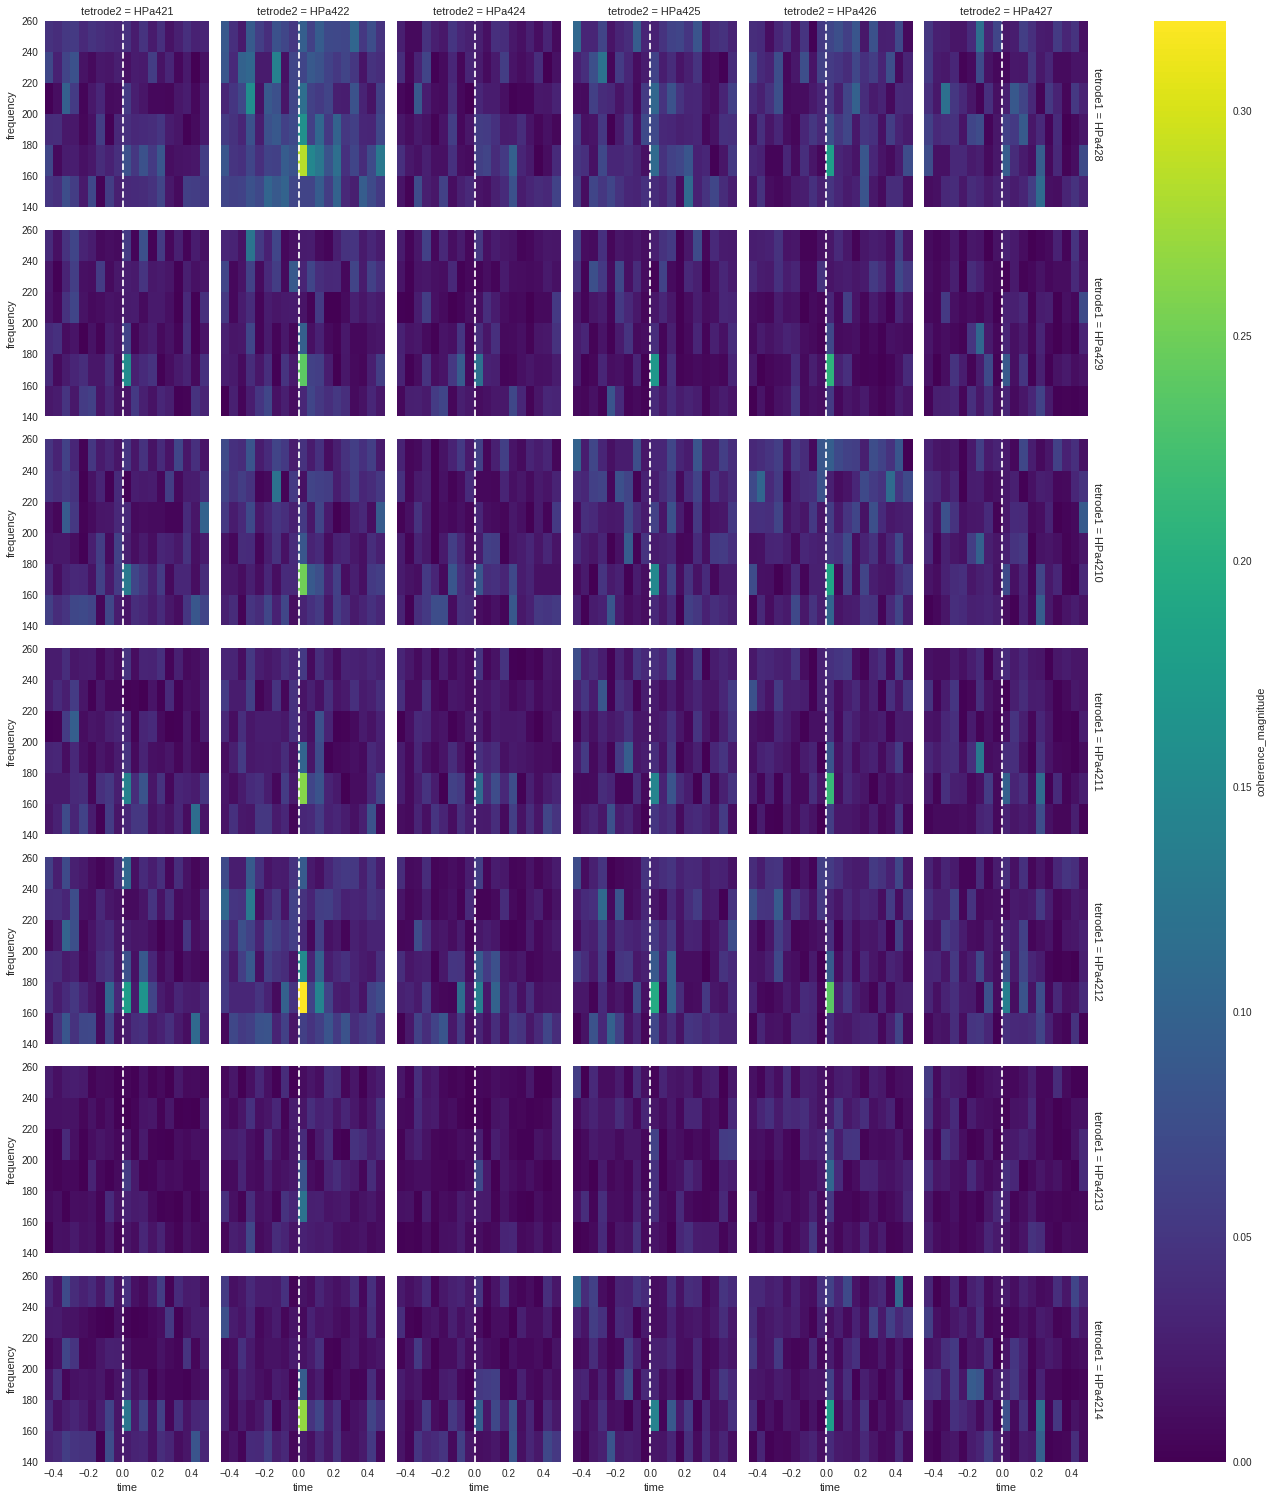

In [44]:
g = coherence_magnitude.sel(
    tetrode1=coherence_magnitude.tetrode1[coherence_magnitude.brain_area1 == 'iCA1'],
    tetrode2=coherence_magnitude.tetrode2[coherence_magnitude.brain_area2 == 'CA1']
).plot(x='time', y='frequency', row='tetrode1', col='tetrode2', vmin=0);

for ax in g.axes.ravel().tolist():
    ax.axvline(0.0, color='white', linestyle='--')

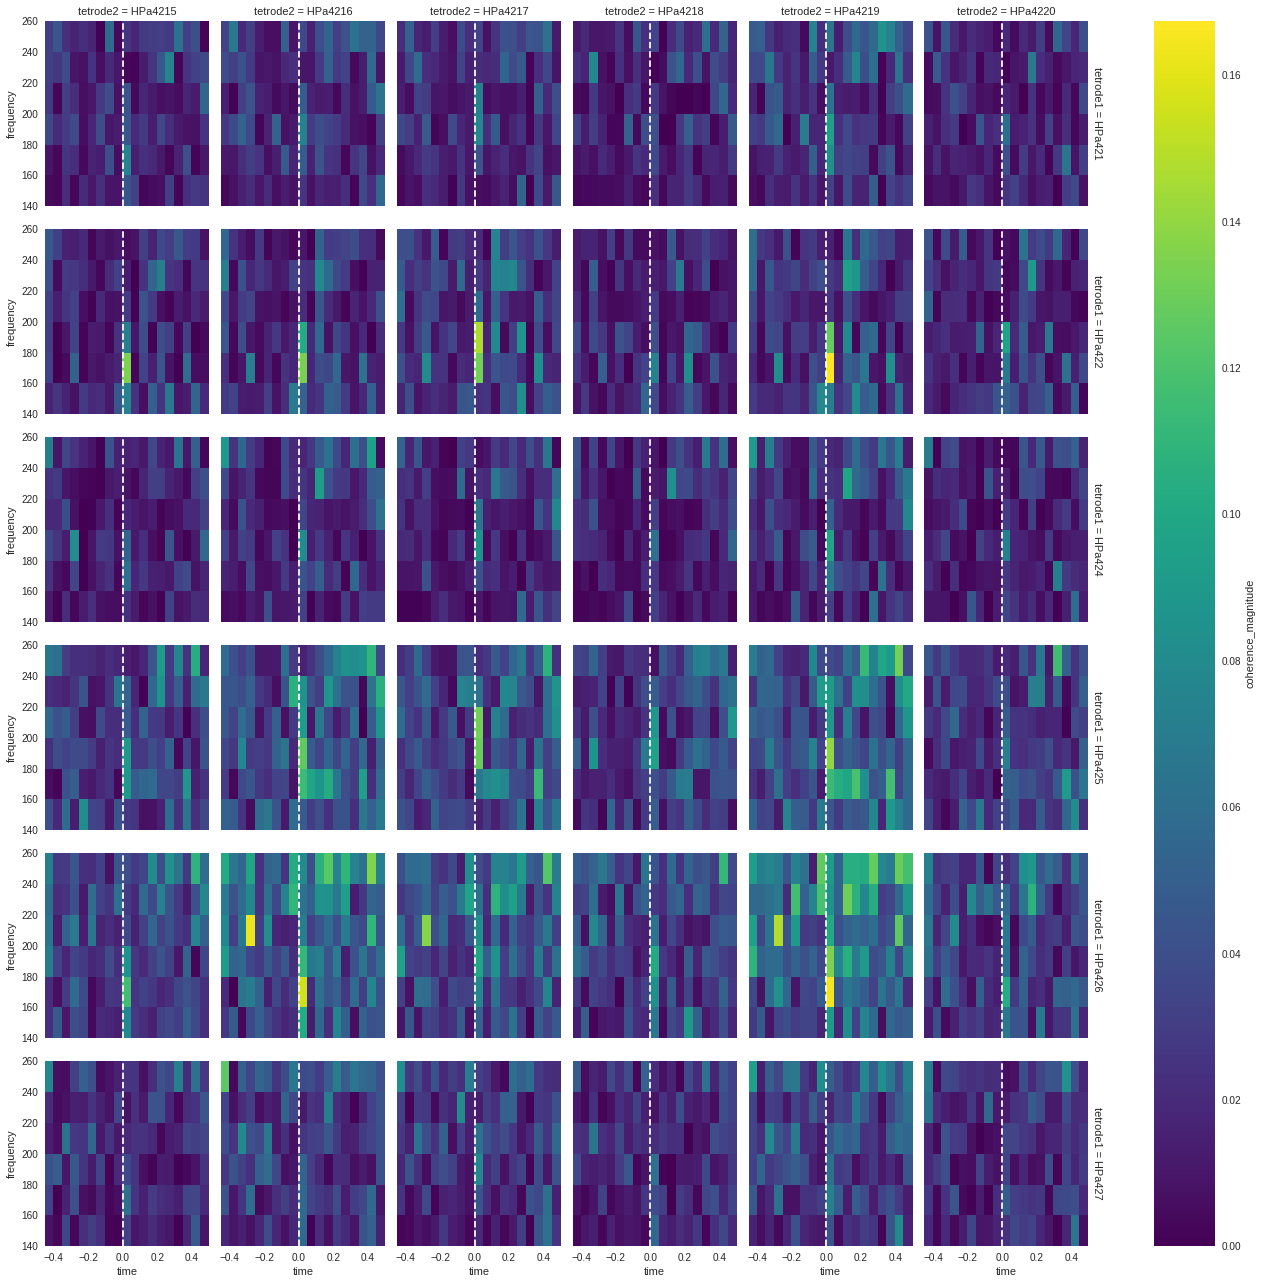

In [43]:
g = coherence_magnitude.sel(
    tetrode1=coherence_magnitude.tetrode1[coherence_magnitude.brain_area1 == 'CA1'],
    tetrode2=coherence_magnitude.tetrode2[coherence_magnitude.brain_area2 == 'PFC']
).plot(x='time', y='frequency', row='tetrode1', col='tetrode2', vmin=0);

for ax in g.axes.ravel().tolist():
    ax.axvline(0.0, color='white', linestyle='--')

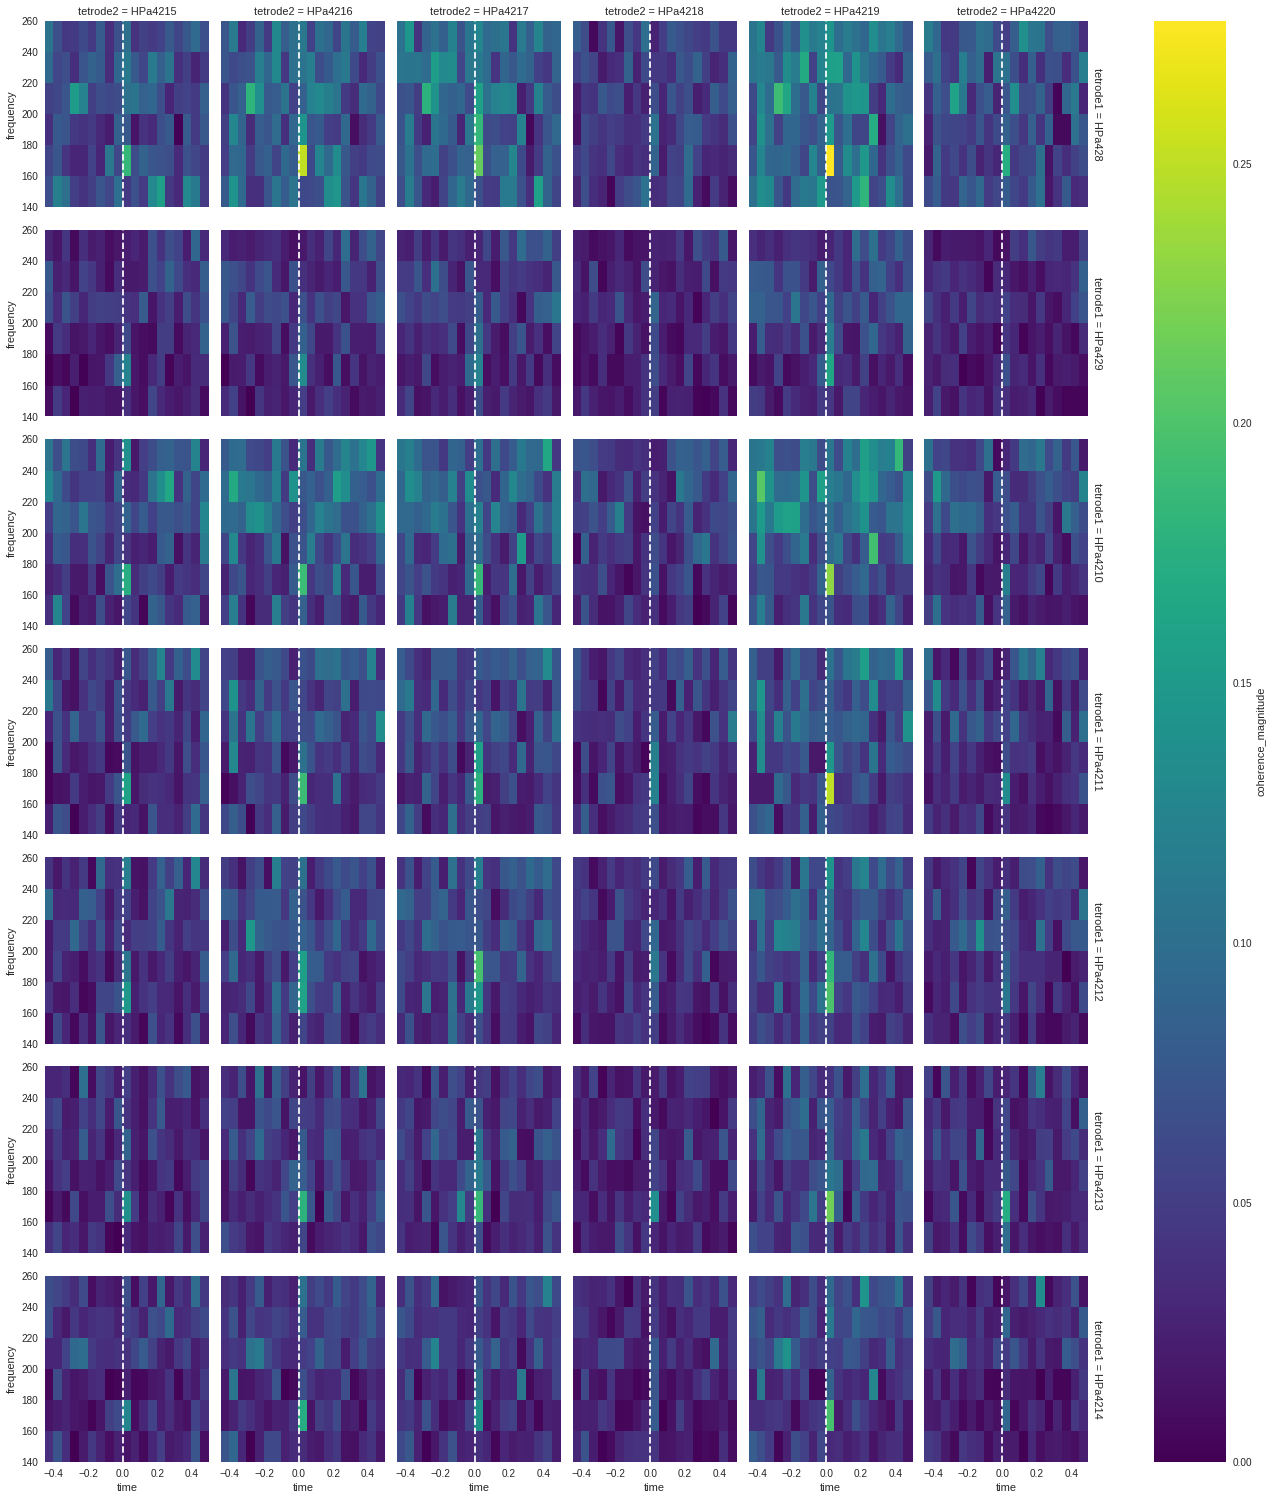

In [42]:
g = coherence_magnitude.sel(
    tetrode1=coherence_magnitude.tetrode1[coherence_magnitude.brain_area1 == 'iCA1'],
    tetrode2=coherence_magnitude.tetrode2[coherence_magnitude.brain_area2 == 'PFC']
).plot(x='time', y='frequency', row='tetrode1', col='tetrode2', vmin=0);


for ax in g.axes.ravel().tolist():
    ax.axvline(0.0, color='white', linestyle='--')

In [59]:
canonical_coherence, area_labels = c.canonical_coherence(
    tetrode_info.area.tolist())
dimension_names = ['time', 'frequency', 'brain_area1', 'brain_area2']
data_vars = {
    'canonical_coherence': (dimension_names, canonical_coherence)}
coordinates = {
    'time': _center_time(c.time),
    'frequency': c.frequencies + np.diff(c.frequencies)[0] / 2,
    'brain_area1': area_labels,
    'brain_area2': area_labels,
}
canonical_coherence = xr.Dataset(data_vars, coords=coordinates).sel(
    frequency=slice(FREQUENCY_BANDS['ripple'][0], FREQUENCY_BANDS['ripple'][1])
).canonical_coherence

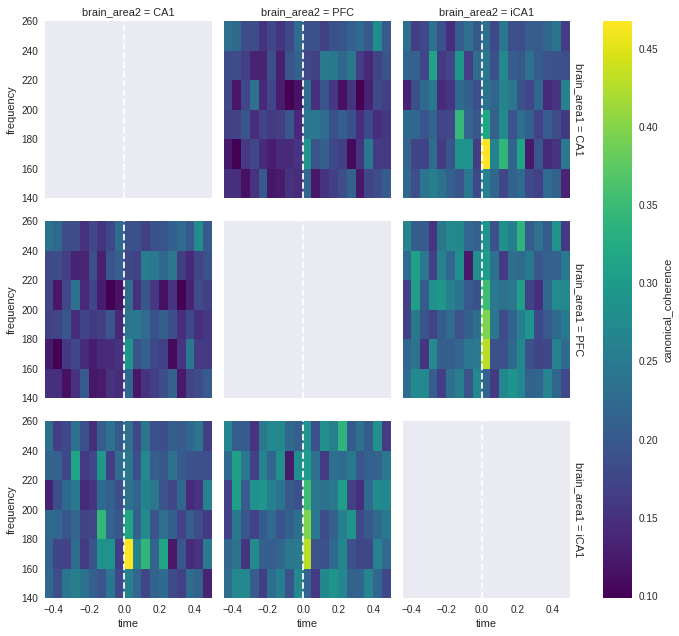

In [60]:
g = canonical_coherence.plot(x='time', y='frequency', row='brain_area1', col='brain_area2');

for ax in g.axes.ravel().tolist():
    ax.axvline(0.0, color='white', linestyle='--')

In [47]:
group_delay = np.array(
    [c.group_delay(FREQUENCY_BANDS[frequency_band],
                   frequency_resolution=m.frequency_resolution)
     for frequency_band in FREQUENCY_BANDS])

dimension_names = ['frequency_band', 'time', 'tetrode1', 'tetrode2']
data_vars = {
    'delay': (dimension_names, group_delay[:, 0, ...]),
    'slope': (dimension_names, group_delay[:, 1, ...]),
    'r_value': (dimension_names, group_delay[:, 2, ...])}

coordinates = {
    'time': _center_time(c.time),
    'frequency_band': list(FREQUENCY_BANDS.keys()),
    'tetrode1': tetrode_info.tetrode_id.values,
    'tetrode2': tetrode_info.tetrode_id.values,
    'brain_area1': ('tetrode1', tetrode_info.area.tolist()),
    'brain_area2': ('tetrode2', tetrode_info.area.tolist()),
    }

group_delay = xr.Dataset(data_vars, coords=coordinates).sel(frequency_band='ripple').delay

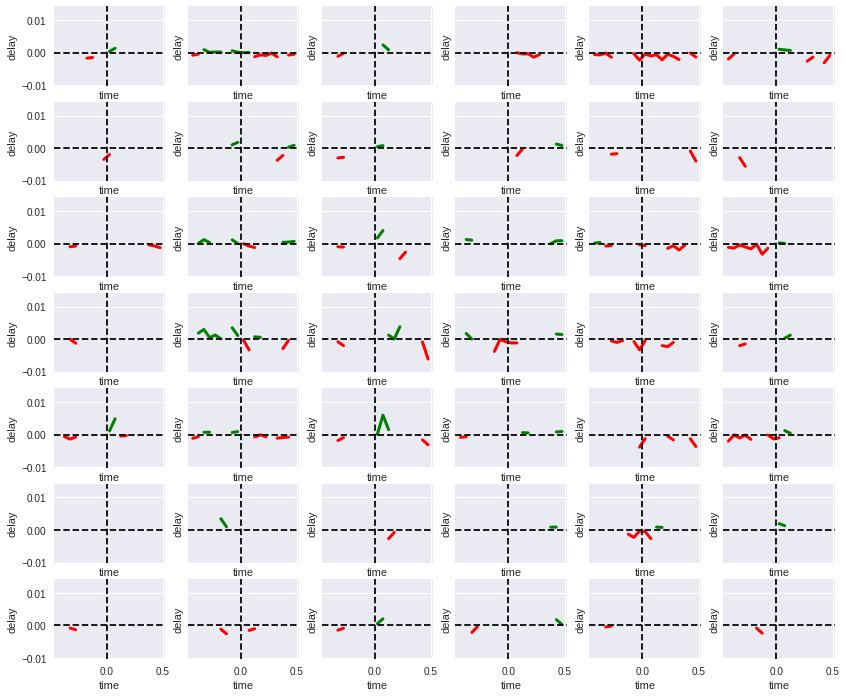

In [54]:
from itertools import product

cur_gd = group_delay.sel(
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'iCA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'CA1'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axvline(0, color='black', linestyle='--')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

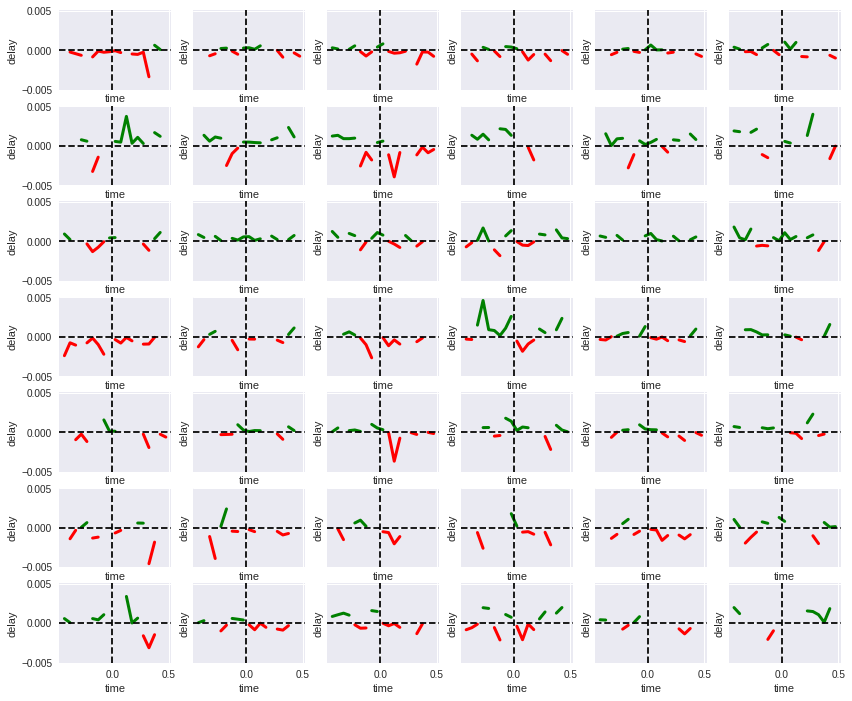

In [53]:
from itertools import product

cur_gd = group_delay.sel(
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'iCA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'PFC'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axvline(0, color='black', linestyle='--')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

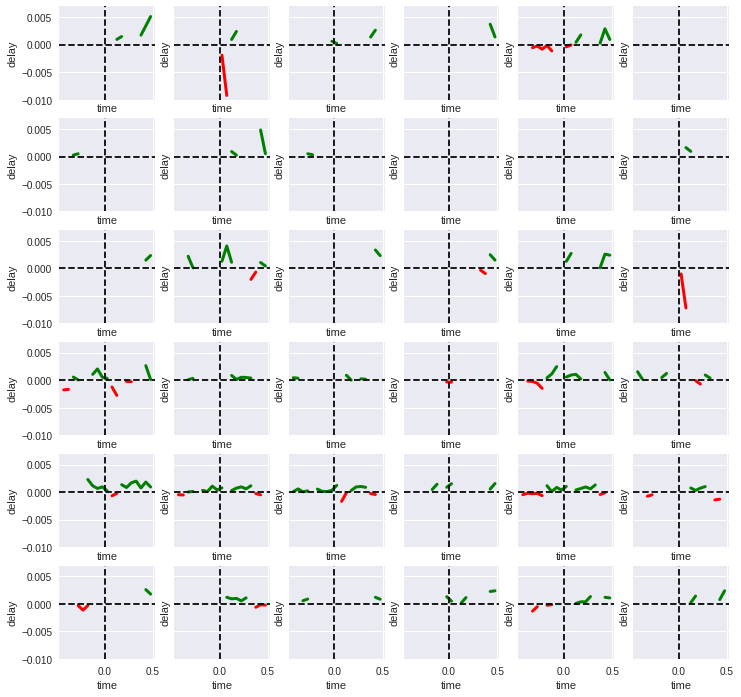

In [52]:
from itertools import product

cur_gd = group_delay.sel(
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'CA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'PFC'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axvline(0, color='black', linestyle='--')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

In [55]:
dimension_names = ['time', 'frequency', 'tetrode1', 'tetrode2']
data_vars = {'pairwise_spectral_granger_prediction': (
    dimension_names, c.pairwise_spectral_granger_prediction())}
coordinates = {
    'time': _center_time(c.time),
    'frequency': c.frequencies + np.diff(c.frequencies)[0] / 2,
    'tetrode1': tetrode_info.tetrode_id.values,
    'tetrode2': tetrode_info.tetrode_id.values,
    'brain_area1': ('tetrode1', tetrode_info.area.tolist()),
    'brain_area2': ('tetrode2', tetrode_info.area.tolist()),
}
spectral_granger = xr.Dataset(data_vars, coords=coordinates).sel(
    frequency=slice(FREQUENCY_BANDS['ripple'][0], FREQUENCY_BANDS['ripple'][1])
).pairwise_spectral_granger_prediction

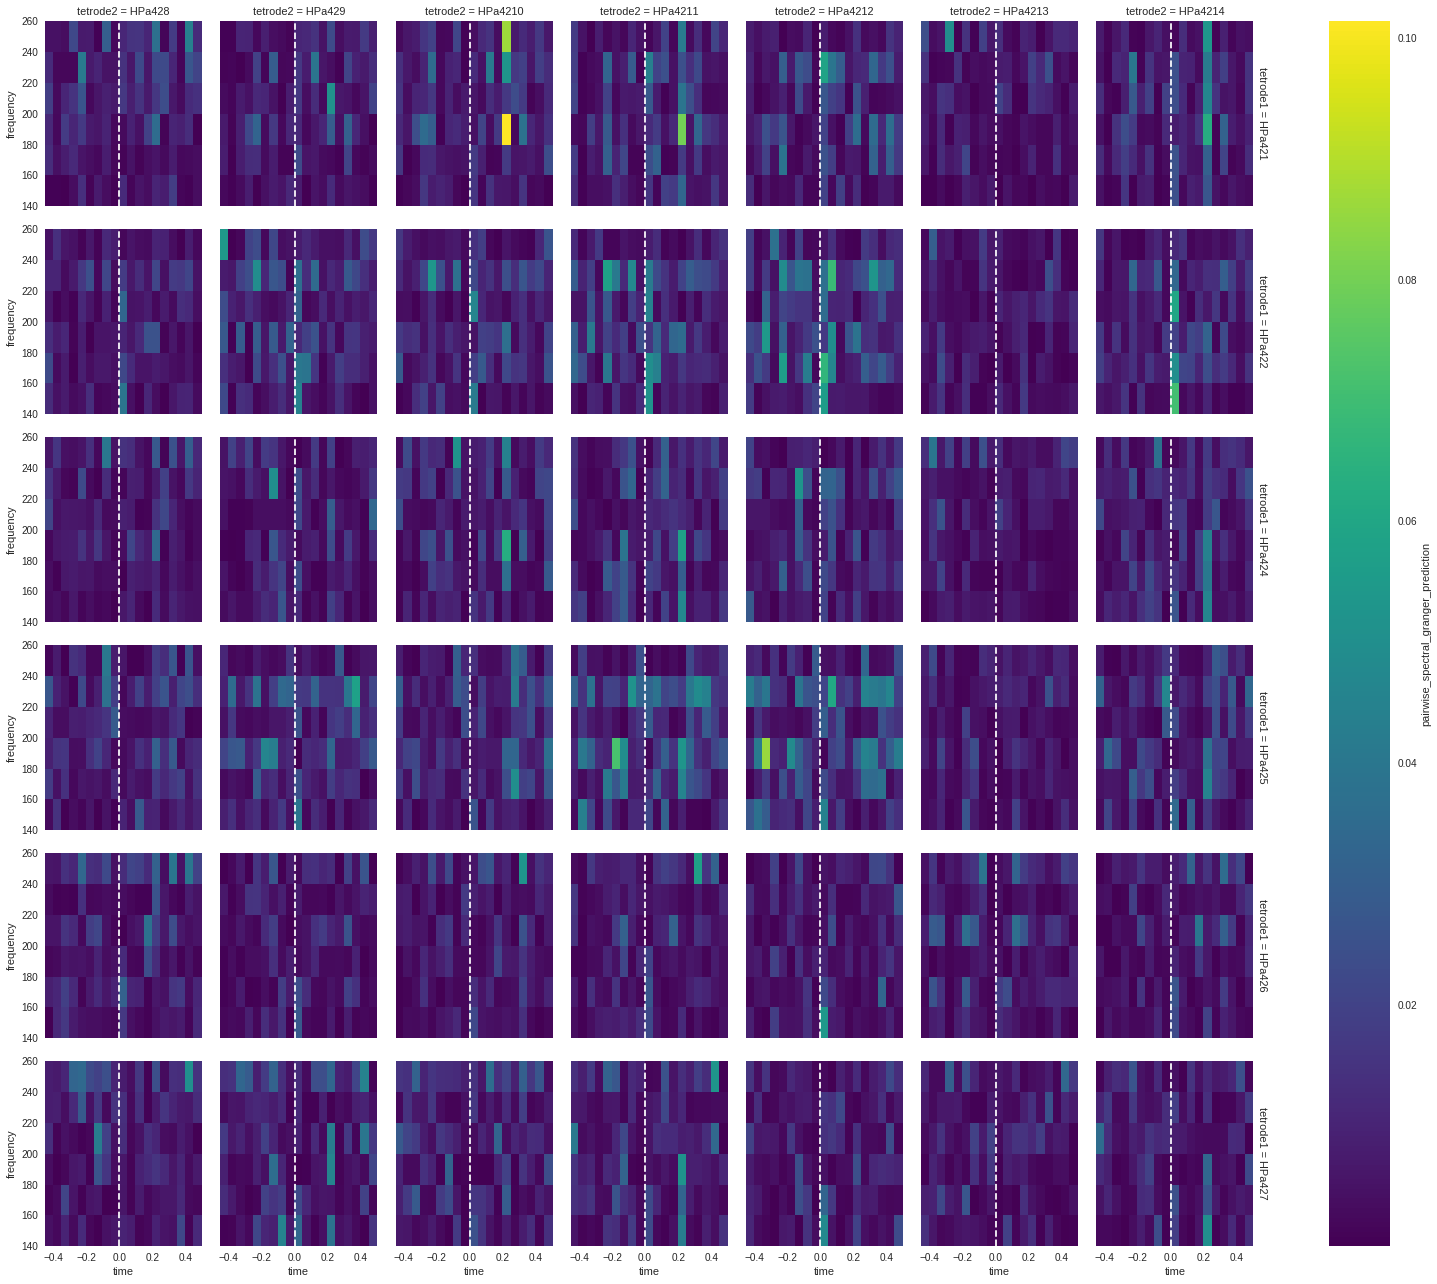

In [61]:
g = spectral_granger.sel(
    tetrode1=spectral_granger.tetrode1[coherence_magnitude.brain_area1 == 'CA1'],
    tetrode2=spectral_granger.tetrode2[coherence_magnitude.brain_area2 == 'iCA1']
).plot(x='time', y='frequency', row='tetrode1', col='tetrode2');

for ax in g.axes.ravel().tolist():
    ax.axvline(0.0, color='white', linestyle='--');

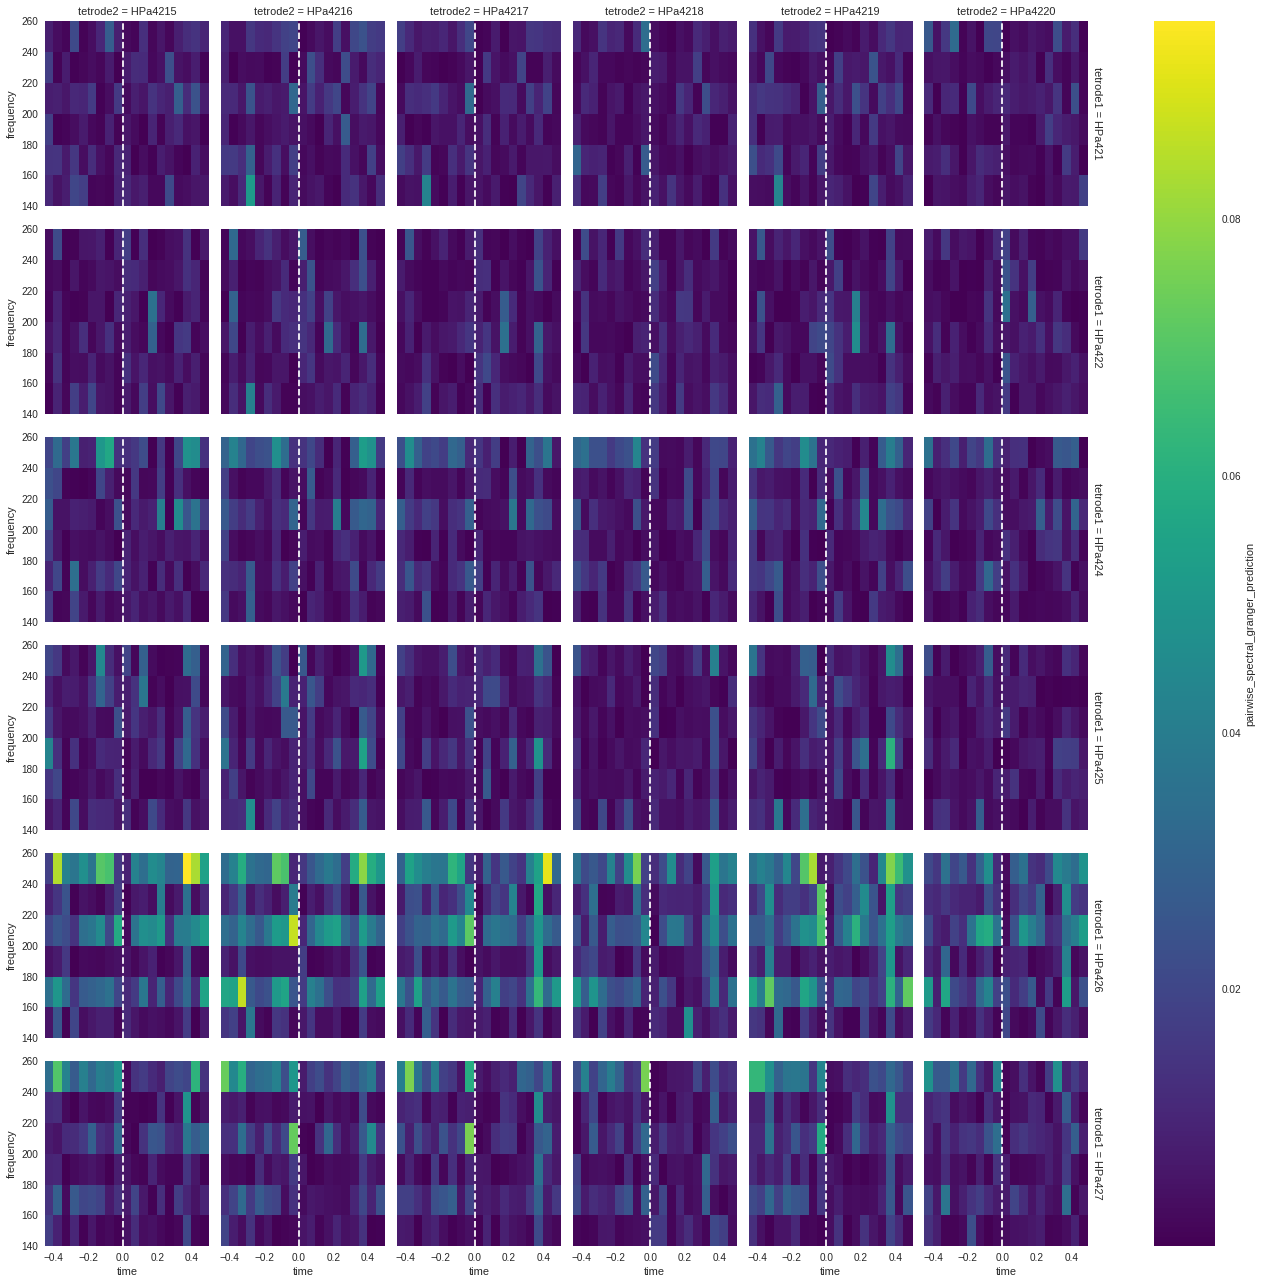

In [62]:
g = spectral_granger.sel(
    tetrode1=spectral_granger.tetrode1[coherence_magnitude.brain_area1 == 'CA1'],
    tetrode2=spectral_granger.tetrode2[coherence_magnitude.brain_area2 == 'PFC']
).plot(x='time', y='frequency', row='tetrode1', col='tetrode2');

for ax in g.axes.ravel().tolist():
    ax.axvline(0.0, color='white', linestyle='--');

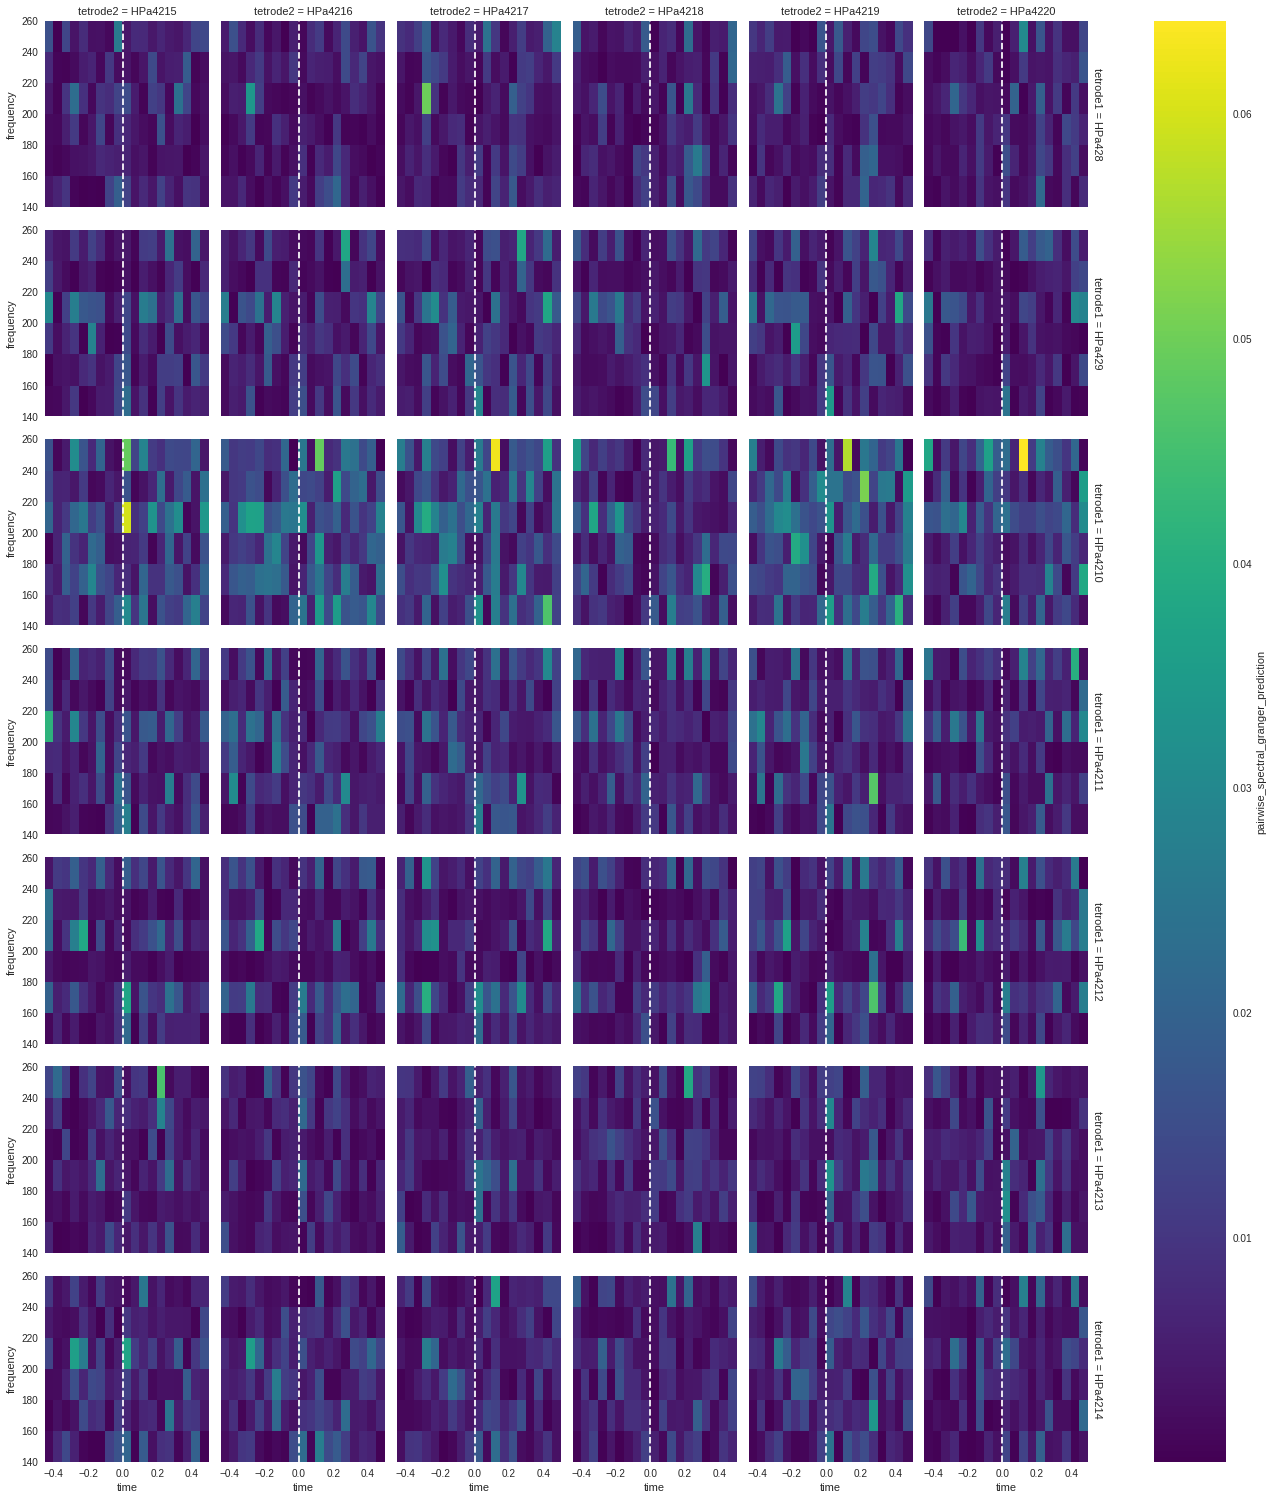

In [64]:
g = spectral_granger.sel(
    tetrode1=spectral_granger.tetrode1[coherence_magnitude.brain_area1 == 'iCA1'],
    tetrode2=spectral_granger.tetrode2[coherence_magnitude.brain_area2 == 'PFC']
).plot(x='time', y='frequency', row='tetrode1', col='tetrode2');

for ax in g.axes.ravel().tolist():
    ax.axvline(0.0, color='white', linestyle='--');

### Whole Trial

In [75]:
position_df = get_interpolated_position_dataframe(
    epoch_key, ANIMALS)

np.rollaxis(pd.Panel(lfps), 0, 3).loc[position_df.speed > 4]

<class 'pandas.core.panel.Panel'>
Dimensions: 1133485 (items) x 1 (major_axis) x 19 (minor_axis)
Items axis: 2701.20926667 to 3900.4906
Major_axis axis: electric_potential to electric_potential
Minor_axis axis: (HPa, 4, 2, 1) to (HPa, 4, 2, 20)

In [76]:
from src.spectral.transforms import Multitaper
from src.spectral.connectivity import Connectivity


m_whole_trial = Multitaper(
    np.rollaxis(pd.Panel(lfps), 0, 3).loc[position_df.speed > 4].values,
    sampling_frequency=SAMPLING_FREQUENCY,
    time_window_duration=50.000,
    time_halfbandwidth_product=5,
    start_time=0
)

c_whole_trial = Connectivity.from_multitaper(m_whole_trial)
m_whole_trial.frequency_resolution

0.1

In [77]:
from src.analysis import _center_time
dimension_names = ['time', 'frequency', 'tetrode']
data_vars = {
     'power': (dimension_names, c_whole_trial.power())}
coordinates = {
    'time': _center_time(c_whole_trial.time),
    'frequency': c_whole_trial.frequencies + np.diff(c_whole_trial.frequencies)[0] / 2,
    'tetrode': tetrode_info.tetrode_id.values,
    'brain_area': ('tetrode', tetrode_info.area.tolist()),
}

power = xr.Dataset(data_vars, coords=coordinates).power

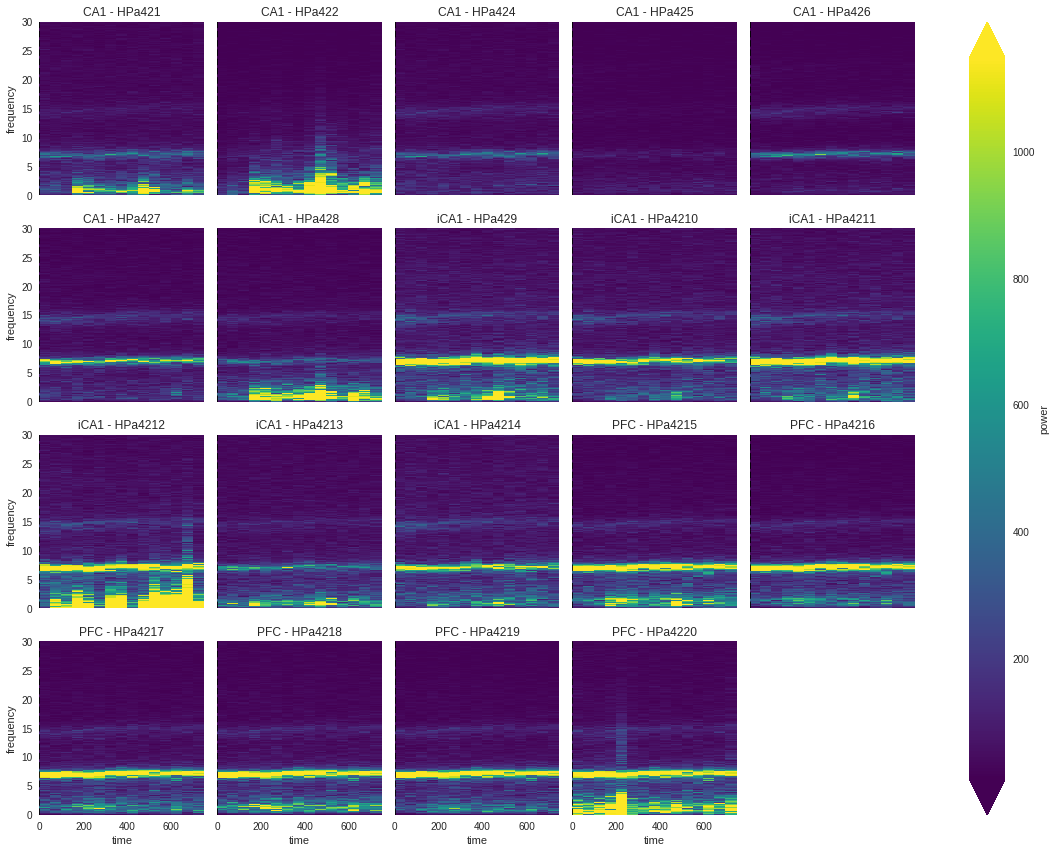

In [80]:
g = power.sel(frequency=slice(0, 30)).plot(x='time', y='frequency', col='tetrode', col_wrap=5, robust=True);

for ax, area, tetrode in zip(g.axes.ravel().tolist(), g.data.brain_area, g.data.tetrode):
    ax.set_title(
        '{brain_area} - {tetrode_id}'.format(brain_area=area.values, tetrode_id=tetrode.values))
    ax.axvline(0, color='black', linestyle='--')

In [81]:
dimension_names = ['time', 'frequency', 'tetrode1', 'tetrode2']
data_vars = {
 'coherence_magnitude': (dimension_names, c_whole_trial.coherence_magnitude())}
coordinates = {
    'time': _center_time(c_whole_trial.time),
    'frequency': c_whole_trial.frequencies + np.diff(c_whole_trial.frequencies)[0] / 2,
    'tetrode1': tetrode_info.tetrode_id.values,
    'tetrode2': tetrode_info.tetrode_id.values,
    'brain_area1': ('tetrode1', tetrode_info.area.tolist()),
    'brain_area2': ('tetrode2', tetrode_info.area.tolist()),
}

coherence_magnitude = xr.Dataset(data_vars, coords=coordinates).coherence_magnitude

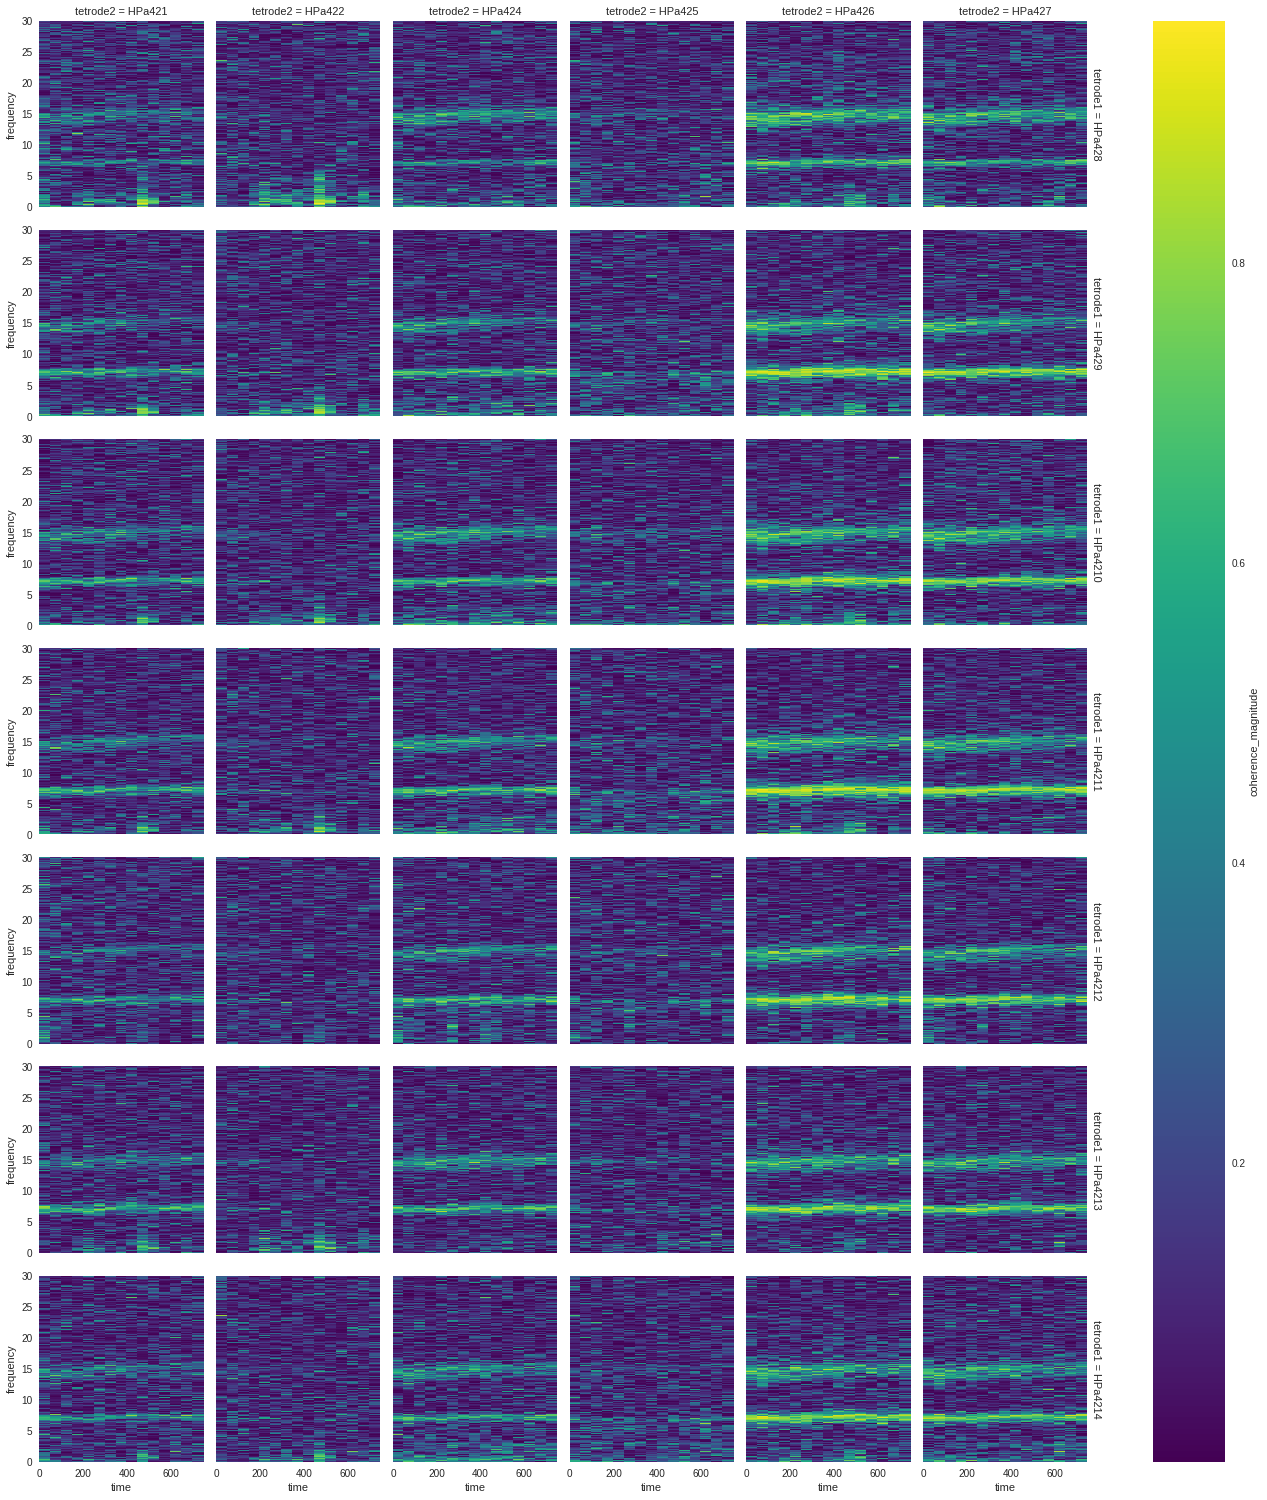

In [90]:
g = coherence_magnitude.sel(
    frequency=slice(0, 30),
    tetrode1=coherence_magnitude.tetrode1[coherence_magnitude.brain_area1 == 'iCA1'],
    tetrode2=coherence_magnitude.tetrode2[coherence_magnitude.brain_area2 == 'CA1']
).plot(x='time', y='frequency', row='tetrode1', col='tetrode2');

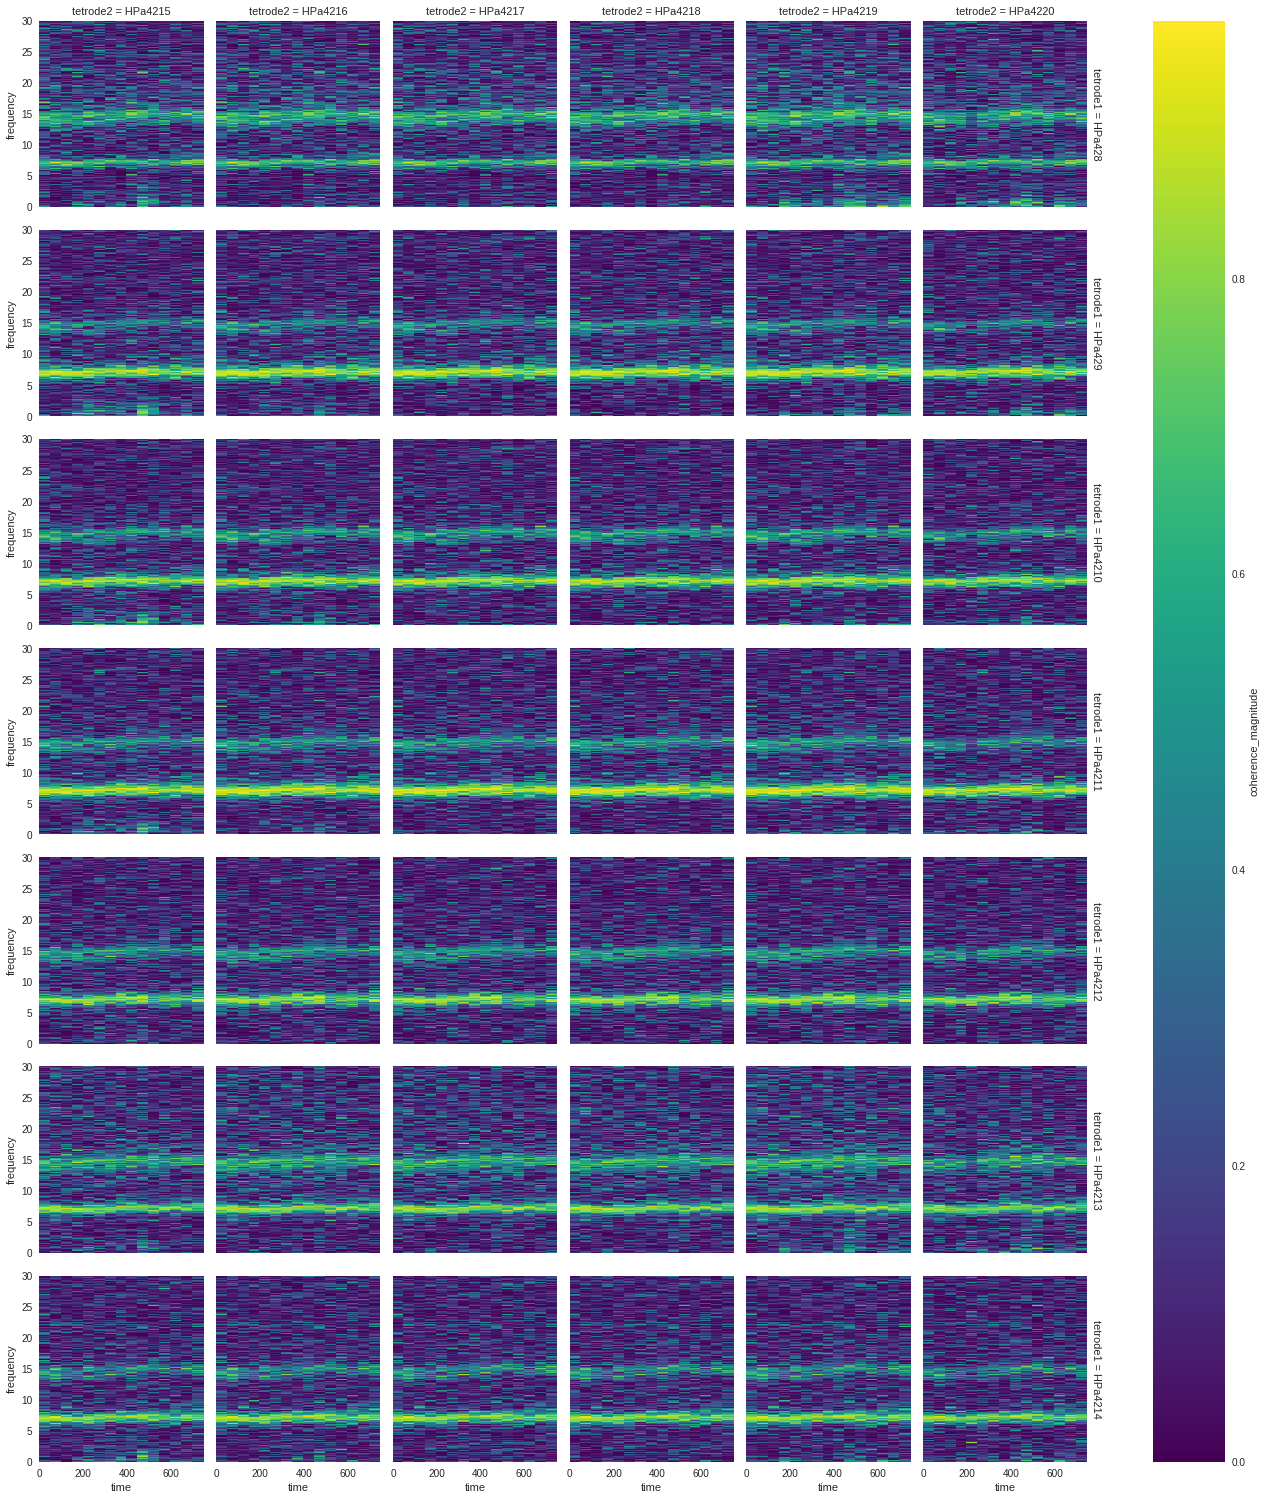

In [89]:
g = coherence_magnitude.sel(
    frequency=slice(0, 30),
    tetrode1=coherence_magnitude.tetrode1[coherence_magnitude.brain_area1 == 'iCA1'],
    tetrode2=coherence_magnitude.tetrode2[coherence_magnitude.brain_area2 == 'PFC']
).plot(x='time', y='frequency', row='tetrode1', col='tetrode2', vmin=0);

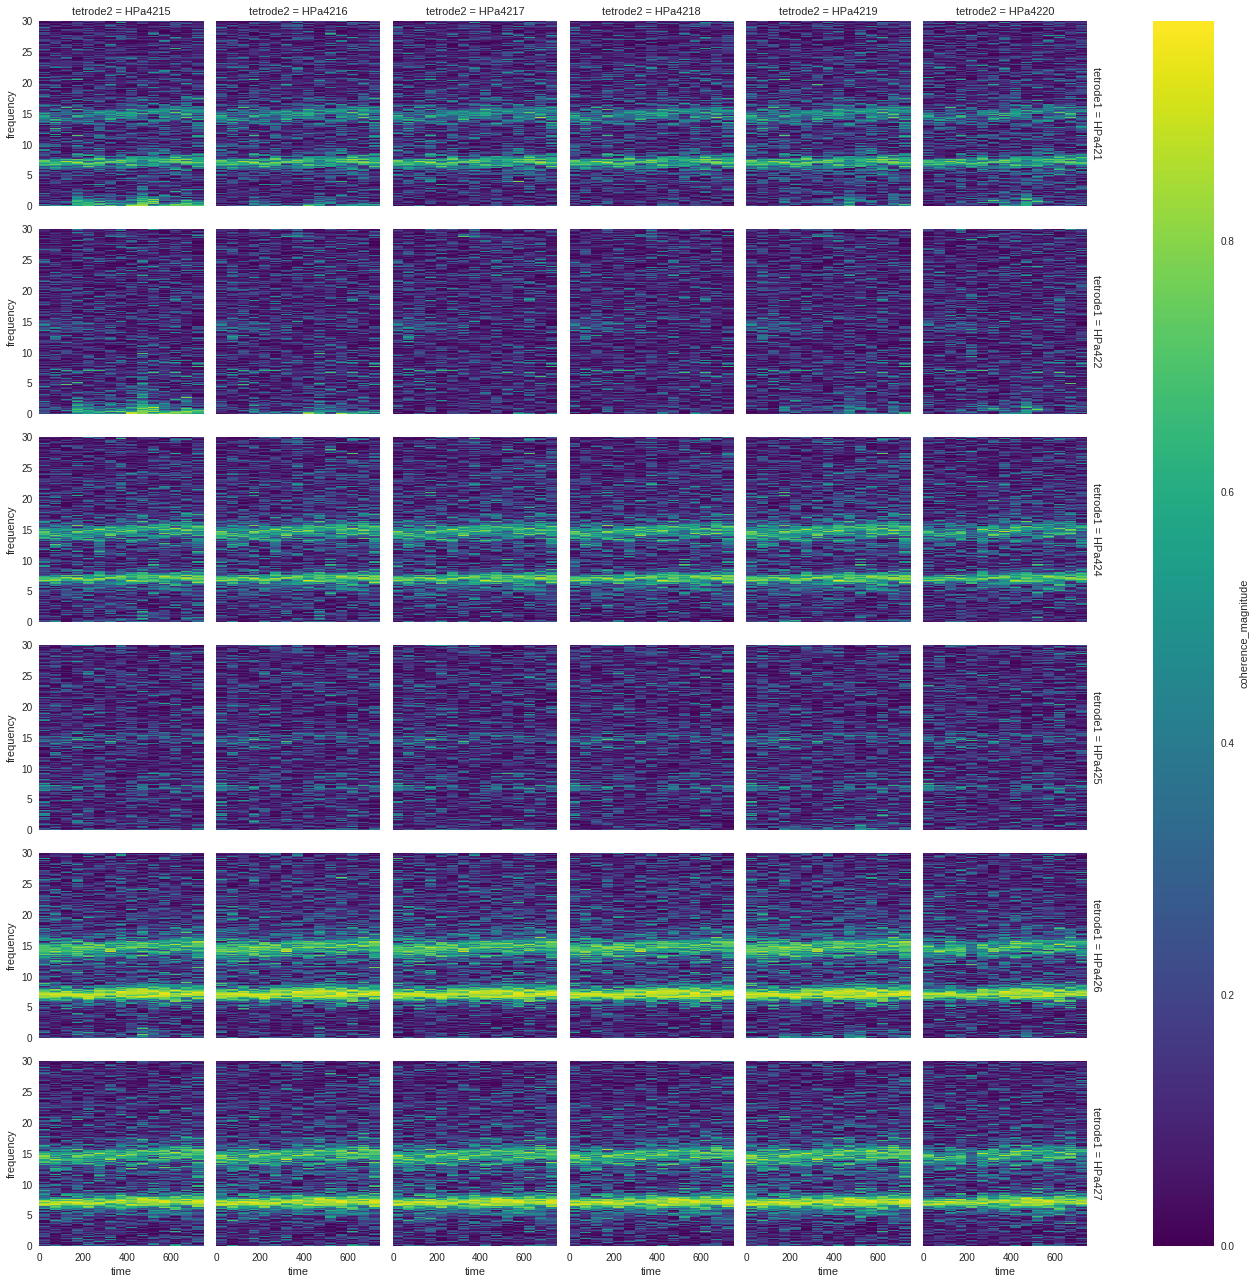

In [88]:
g = coherence_magnitude.sel(
    frequency=slice(0, 30),
    tetrode1=coherence_magnitude.tetrode1[coherence_magnitude.brain_area1 == 'CA1'],
    tetrode2=coherence_magnitude.tetrode2[coherence_magnitude.brain_area2 == 'PFC']
).plot(x='time', y='frequency', row='tetrode1', col='tetrode2', vmin=0);

In [91]:
group_delay = np.array(
    [c_whole_trial.group_delay(FREQUENCY_BANDS[frequency_band],
                   frequency_resolution=m_whole_trial.frequency_resolution)
     for frequency_band in FREQUENCY_BANDS])

dimension_names = ['frequency_band', 'time', 'tetrode1', 'tetrode2']
data_vars = {
    'delay': (dimension_names, group_delay[:, 0, ...]),
    'slope': (dimension_names, group_delay[:, 1, ...]),
    'r_value': (dimension_names, group_delay[:, 2, ...])}

coordinates = {
    'time': _center_time(c_whole_trial.time),
    'frequency_band': list(FREQUENCY_BANDS.keys()),
    'tetrode1': tetrode_info.tetrode_id.values,
    'tetrode2': tetrode_info.tetrode_id.values,
    'brain_area1': ('tetrode1', tetrode_info.area.tolist()),
    'brain_area2': ('tetrode2', tetrode_info.area.tolist()),
    }

group_delay = xr.Dataset(data_vars, coords=coordinates).delay

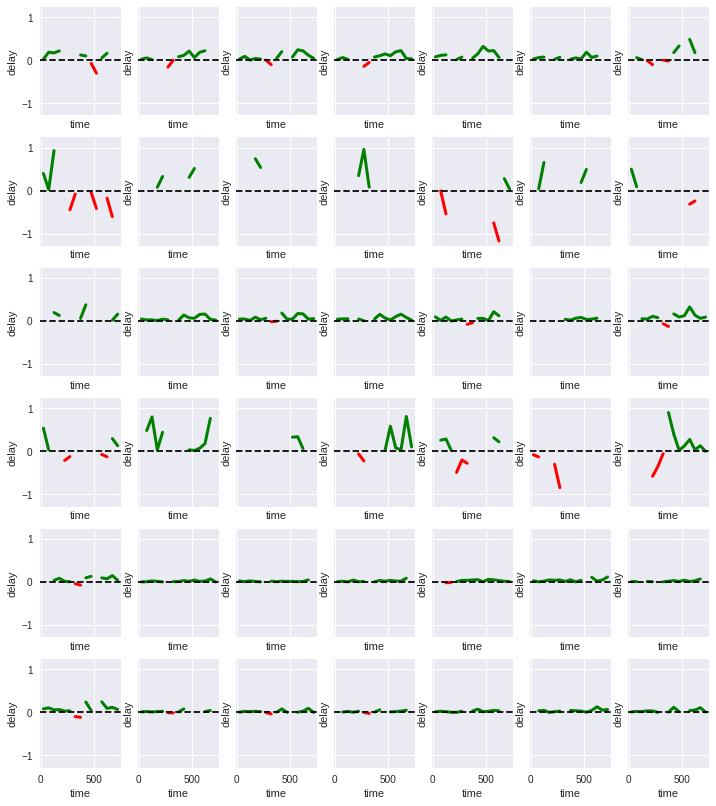

In [98]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='theta',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'CA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'iCA1'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

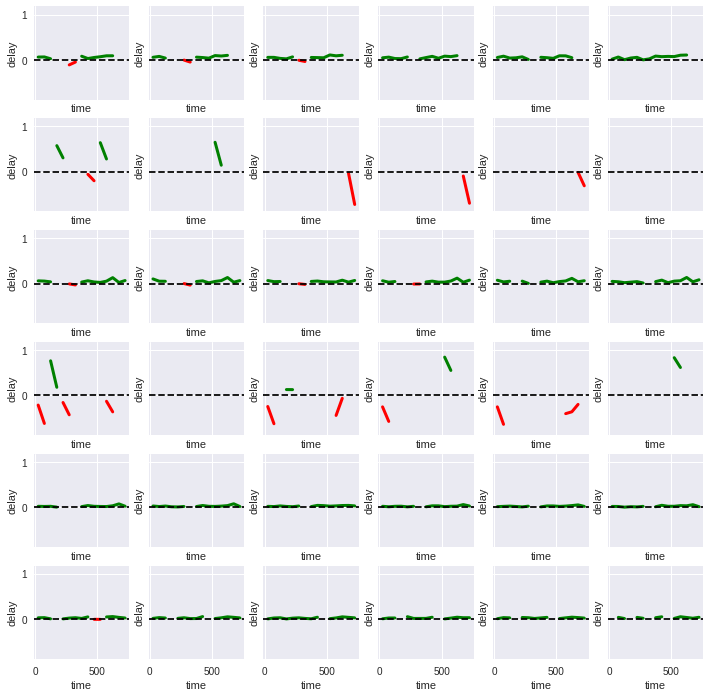

In [96]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='theta',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'CA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'PFC'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

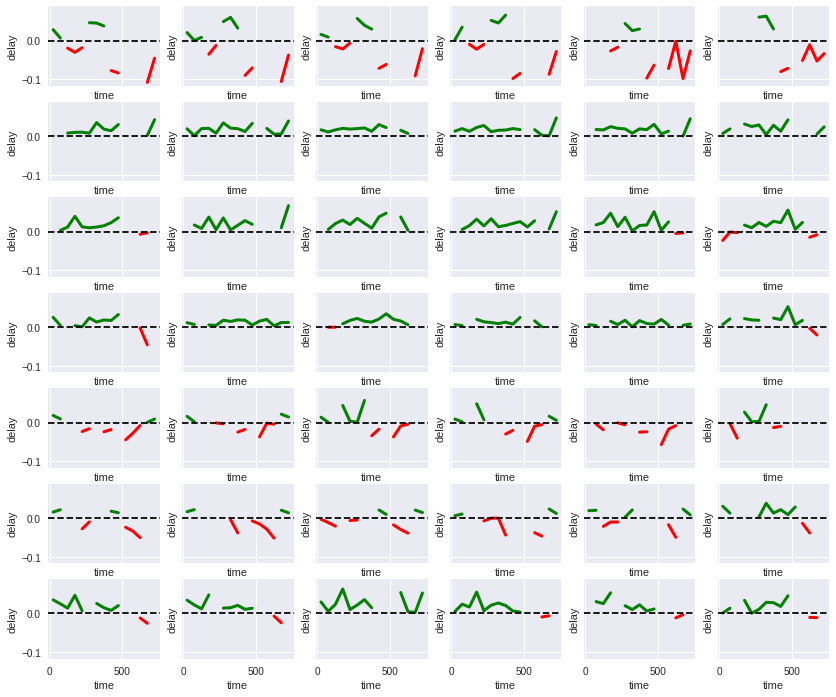

In [97]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='theta',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'iCA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'PFC'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

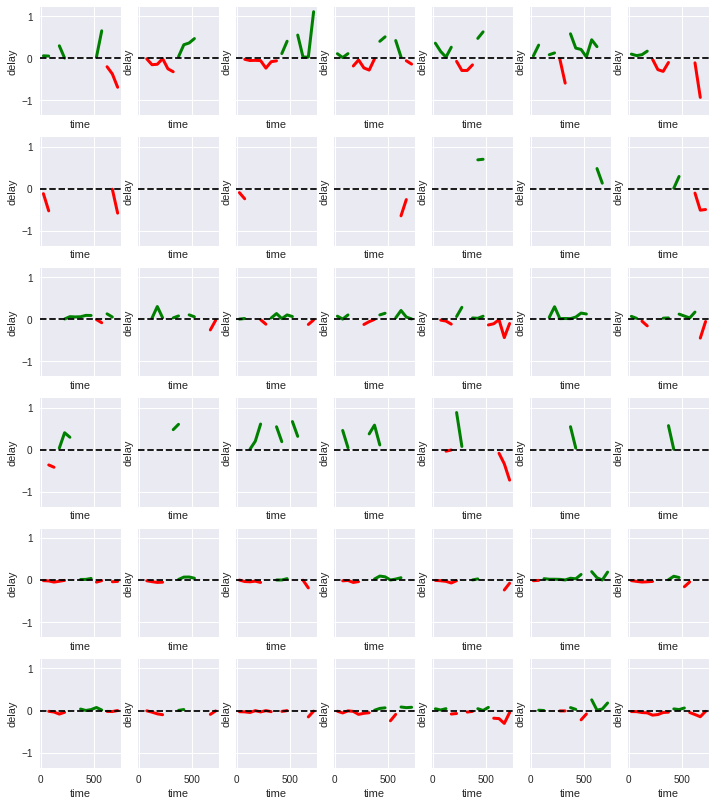

In [100]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='beta',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'CA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'iCA1'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

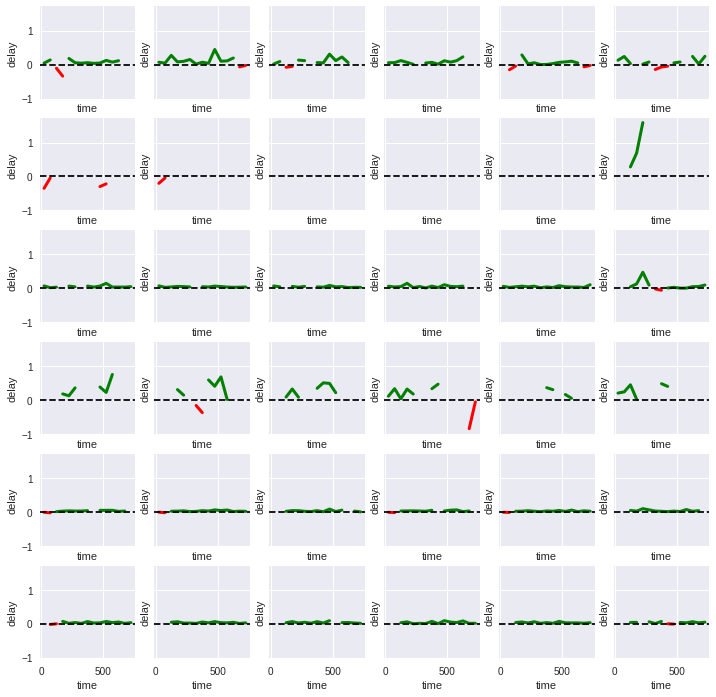

In [101]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='beta',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'CA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'PFC'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

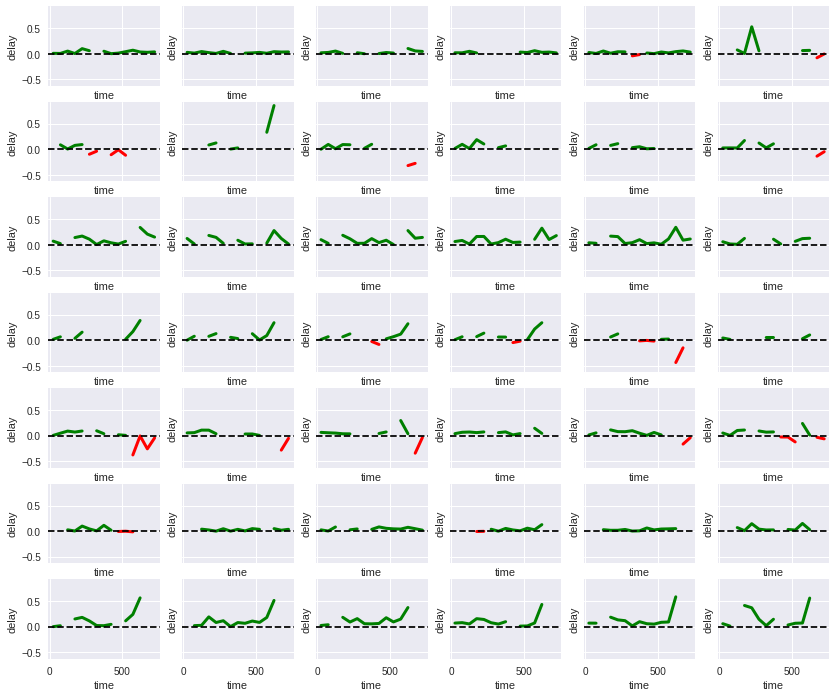

In [102]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='beta',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'iCA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'PFC'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

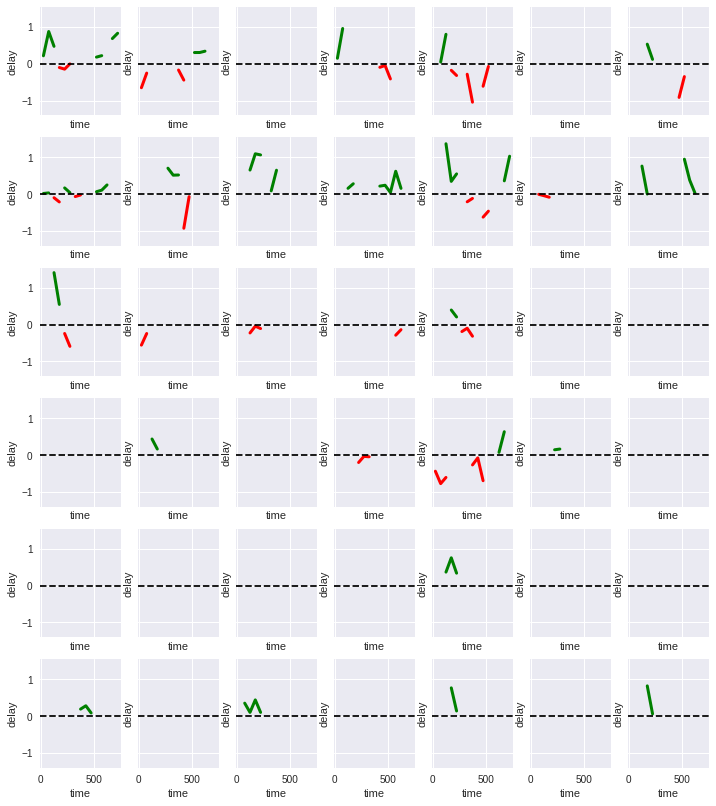

In [103]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='slow_gamma',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'CA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'iCA1'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

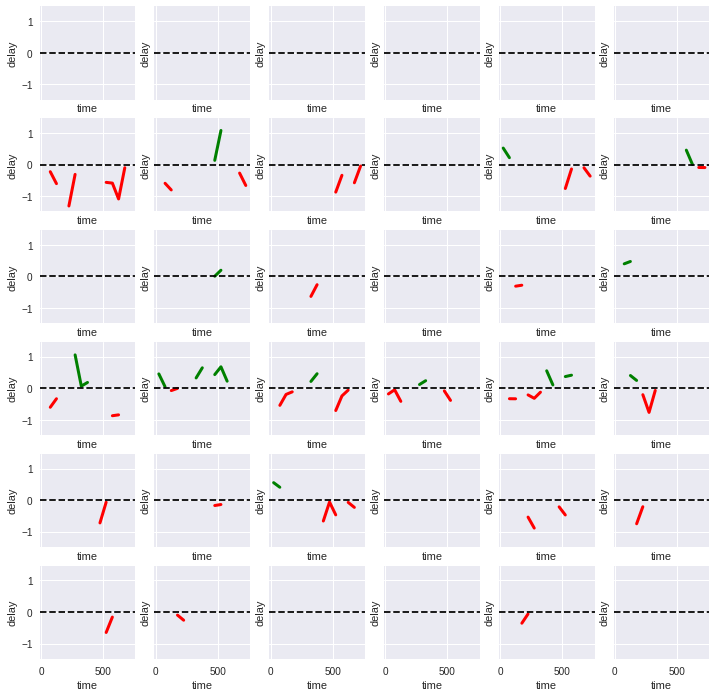

In [104]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='slow_gamma',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'CA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'PFC'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

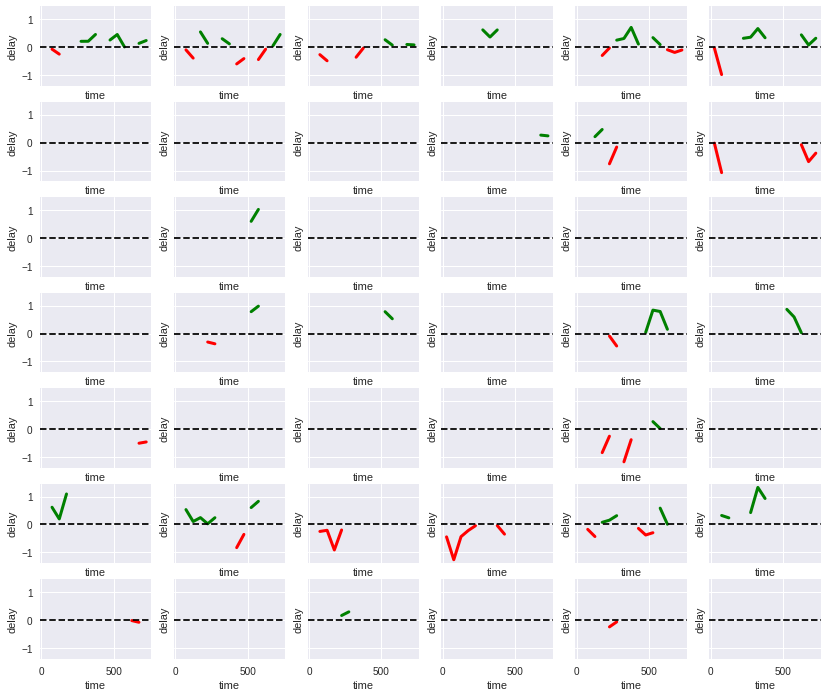

In [105]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='slow_gamma',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'iCA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'PFC'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

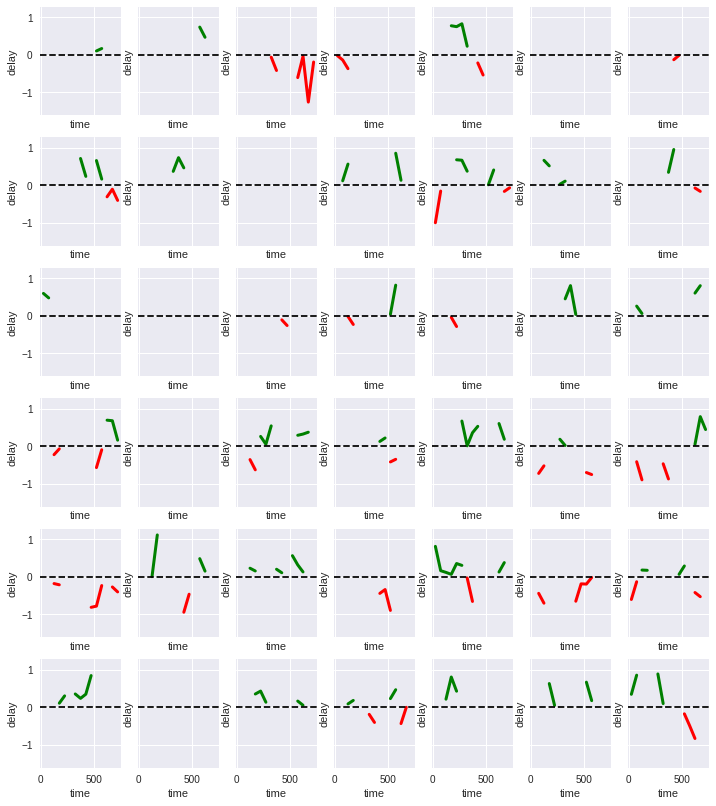

In [106]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='ripple',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'CA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'iCA1'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

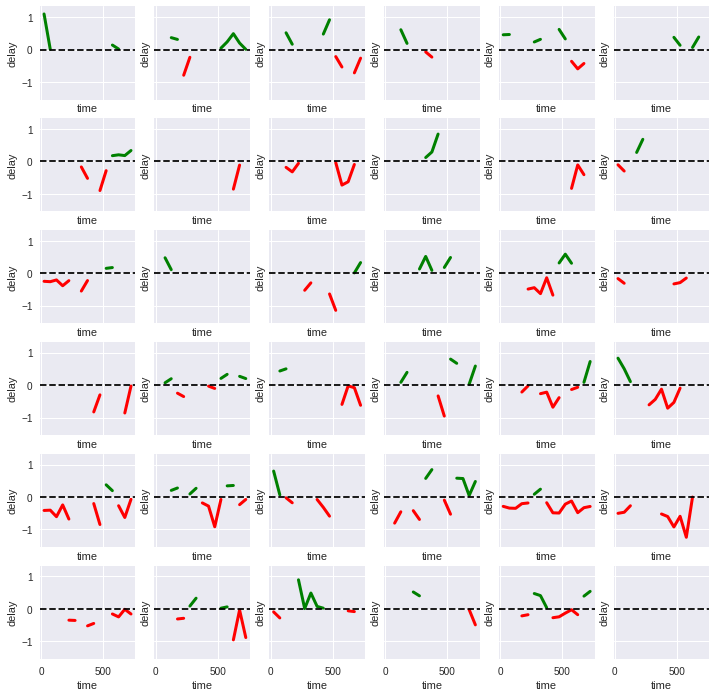

In [107]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='ripple',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'CA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'PFC'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

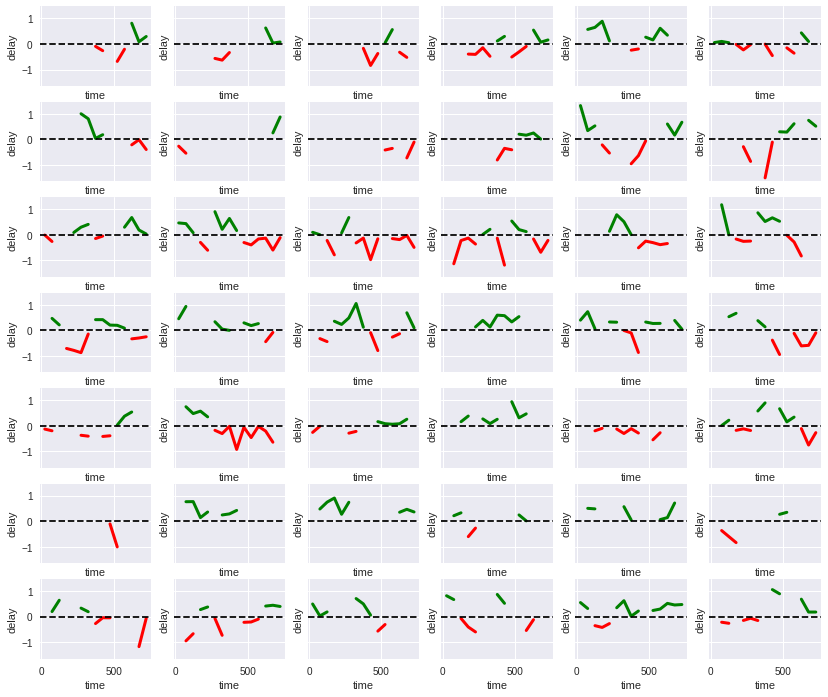

In [108]:
from itertools import product

cur_gd = group_delay.sel(
    frequency_band='ripple',
    tetrode1=group_delay.tetrode1[group_delay.brain_area1 == 'iCA1'],
    tetrode2=group_delay.tetrode2[group_delay.brain_area2 == 'PFC'])
_, n_tetrodes1, n_tetrodes2 = cur_gd.shape

fig, ax = plt.subplots(n_tetrodes1, n_tetrodes2,
                       sharex=True, sharey=True, figsize=(n_tetrodes1 * 2, n_tetrodes2 * 2))

for ind1, ind2 in product(range(n_tetrodes1), range(n_tetrodes2)):
    delay = cur_gd.isel(tetrode1=ind1, tetrode2=ind2)
    delay.where(delay > 0).plot(ax=ax[ind1, ind2], linewidth=3, color='green');
    delay.where(delay < 0).plot(ax=ax[ind1, ind2], linewidth=3, color='red');
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')

In [99]:
dimension_names = ['time', 'frequency', 'tetrode1', 'tetrode2']
data_vars = {'pairwise_spectral_granger_prediction': (
    dimension_names, c_whole_trial.pairwise_spectral_granger_prediction())}
coordinates = {
    'time': _center_time(c_whole_trial.time),
    'frequency': c_whole_trial.frequencies + np.diff(c_whole_trial.frequencies)[0] / 2,
    'tetrode1': tetrode_info.tetrode_id.values,
    'tetrode2': tetrode_info.tetrode_id.values,
    'brain_area1': ('tetrode1', tetrode_info.area.tolist()),
    'brain_area2': ('tetrode2', tetrode_info.area.tolist()),
}
spectral_granger = xr.Dataset(data_vars, coords=coordinates).pairwise_spectral_granger_prediction

KeyboardInterrupt: 